# Import Libraries

In [1]:
import torch
print(torch.__version__)
import torchvision
import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

2.6.0


# GPU/CUDA setup

In [2]:
# if torch.cuda.is_available():
#     print("CUDA enabled!")
# device = 'cuda:0'
# os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(f'{i}' for i in range(1))

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Autoencoder Helpers

In [3]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = torch.reshape(list_of_norms(X), shape=(-1, 1))

    YY = torch.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * torch.matmul(X, torch.transpose(Y, 0, 1))
    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2),dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')



# Network Modules

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels=1, n_maps=32, out_channels=10, n_layers=4):
        super(EncoderLayer, self).__init__()
        
        el = []
        el += [ConvLayer(in_channels, n_maps, stride=2, padding=1)]
        for i in range(0, n_layers-2):
            el += [ConvLayer(n_maps, n_maps, stride=2, padding=1)]   
        el += [ConvLayer(n_maps, out_channels, stride=2, padding=1)]

        self.encoder = nn.Sequential(*el)

    def forward(self, x):
        return self.encoder(x)

class DecoderLayer(nn.Module):
    def __init__(self, in_channels=10, n_maps=32, out_channels=1, out_shapes=[], n_layers=4):
        super(DecoderLayer, self).__init__()

        dl = []
        dl += [DeConvLayer(in_channels, n_maps, out_shape=out_shapes[-1], stride=2, padding=1, output_padding=1)]
        for i in range(1, n_layers-1):
            dl += [DeConvLayer(n_maps, n_maps, out_shape=out_shapes[-(i+1)], stride=2, padding=1, output_padding=1)]
        dl += [DeConvLayer(n_maps, out_channels, out_shape=out_shapes[-n_layers], stride=2, padding=1, 
                           output_padding=1, activation=nn.Sigmoid)]

        self.decoder = nn.Sequential(*dl)

    def forward(self, x):
        return self.decoder(x)

class PrototypeLayer(nn.Module):
    def __init__(self, in_channels=10, n_prototypes=15):
        super(PrototypeLayer, self).__init__()

        self.prototype_distances = torch.rand(n_prototypes, in_channels, requires_grad=True).to(device)

    def forward(self, x):
        return list_of_distances(x, self.prototype_distances)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                             stride=stride, padding=padding)
        self.activation = activation()

    def forward(self, x):
        self.in_dim = x.shape[-2:]
        return self.activation(self.conv(x)) 

class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, out_shape, stride=2, padding=1, output_padding=1, activation=nn.ReLU):
        super(DeConvLayer, self).__init__()
        self.out_shape = out_shape
        self.dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, 
                                        stride=stride, padding=padding, output_padding=output_padding)
        self.activation = activation()

    def forward(self, x):
        out_convt = self.dconv(x)
        if (out_convt.shape[-2:][0] != self.out_shape[0]) & (out_convt.shape[-2:][1] != self.out_shape[1]):
            out_convt = out_convt[:,:,(out_convt.shape[-2:][0] - self.out_shape[0]):,
                                 (out_convt.shape[-2:][1] - self.out_shape[1]):]
        return self.activation(out_convt)

class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features=15, out_features=10):
        super(FullyConnectedLayer, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.linear(x)
    
class IdentityLayer(nn.Module):
    def __init__(self, out_features=10, prototypes_by_class=3, fill_with=0.5):
        super(IdentityLayer, self).__init__()
        self.linear = nn.Linear(out_features * prototypes_by_class, out_features, bias=False)
        
        w = torch.full((out_features, out_features * prototypes_by_class), fill_with)
        for i in range(out_features):
            w[i, i * prototypes_by_class:(i + 1) * prototypes_by_class] = -1
        self.linear.weight = nn.Parameter(w)  

    def forward(self, x):
        return self.linear(x)
    
class Softmax(nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(x)

# CAE Model definition

In [28]:
class CAEModel(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(CAEModel, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out
   
class S15(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(S15, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out
    
class S30(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=30, n_layers=4, n_classes=10):
        super(S30, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out
    
class B30(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, prototypes_by_class=3, n_layers=4, n_classes=10, fill_with=0.5):
        super(B30, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=int(prototypes_by_class*n_classes))

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # final fully connected layer
        # CHANGED !! 
        self.fc = IdentityLayer(prototypes_by_class=prototypes_by_class, out_features=n_classes, fill_with=fill_with)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out

# Data Processing

In [29]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_3685/1429368971.py:7: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_3685/1429368971.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# MINIST Data Loader

In [30]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# function to load and return train and val multi-process iterator over the MNIST dataset.

def get_train_val_loader(data_dir, batch_size, random_seed, augment=False, val_size=0.2, 
                         shuffle=True, show_sample=False, num_workers=0, pin_memory=True):

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())
    val_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # create data iterator
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                               num_workers=num_workers, pin_memory=pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, 
                                             num_workers=num_workers, pin_memory=pin_memory)
    return (train_loader, val_loader)

# function to load and return a multi-process test iterator over the MNIST dataset.
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True):

    dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                                              num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

# The directory to save the model

In [31]:
model_type = "todo"

In [33]:
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model",model_type)
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"

# console_log is the handle to a text file that records the console output
log_folder=os.path.join(model_folder, "log")
makedirs(log_folder)
console_log = open(os.path.join(log_folder, "console_log.txt"), "w+")

# Model parameters

In [34]:
# training parameters
learning_rate = 0.002
training_epochs = 100 #1500
batch_size = 250              # the size of a minibatch
test_display_step = 100       # how many epochs we do evaluate on the test set once
save_step = 5                # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha =20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1            # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# input data parameters
input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
input_shape = (1, n_input_channel, input_height, input_height) # input shape to pass in the model
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4
n_maps = 32

# Load MNIST Data

In [35]:
#you may need to install the following packages in your python environment if it fails to donload data.
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension
# the following two for jupyter hosted environment
#conda install -n base -c conda-forge widgetsnbextension
#conda install -n <your_environment_name> -c conda-forge ipywidgets


In [36]:
# data load and split parameters
random_seed = 1
n_workers = 0
data_folder = 'data'

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Get the CAE model

In [37]:
model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                 n_layers=n_layers, n_classes=n_classes).to(device)

In [38]:
# model selection
if model_type == 'S15':
    # n_prototypes =  15   
    model = S15(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                n_layers=n_layers, n_classes=n_classes).to(device)
elif model_type == 'S30':
    n_prototypes =  30
    model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=30, 
                n_layers=n_layers, n_classes=n_classes).to(device)
elif model_type == 'B30':
    n_prototypes =  30
    model = B30(input_shape=input_shape, n_maps=n_maps, prototypes_by_class=3, 
                n_layers=n_layers, n_classes=n_classes, fill_with=0.5).to(device)


# Optimizer setup

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST data

## train loop

################################################################################
Epoch: 0001/0100
batch: 001:   1%|          | 1/192 [00:00<00:51,  3.68it/s]

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_3685/1429368971.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  e_images[:] = images


batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.43it/s]
training set errors:	classification error: 0.860294	autoencoder error: 0.045370	error_1: 2.643381	error_2: 4.459983	total error: 24.354607	accuracy: 0.375396
training takes 16.84 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.63it/s]
validation set errors:	classification error: 0.676464	autoencoder error: 0.054437	error_1: 3.197051	error_2: 5.280573	total error: 22.061344	accuracy: 0.855083
################################################################################
Epoch: 0002/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.85it/s]
training set errors:	classification error: 0.408087	autoencoder error: 0.042735	error_1: 2.367901	error_2: 3.655827	total error: 14.228197	accuracy: 0.870938
training takes 16.21 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.58it/s]
validation set errors:	classification error: 0.245538	autoencoder error: 0.047795	error_1: 2.578968	error_2: 4.070279	tota

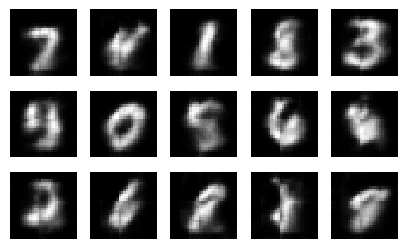

Visualizing encoded and decoded images:


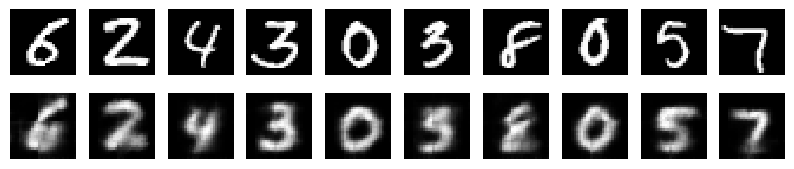

################################################################################
Epoch: 0006/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.85it/s]
training set errors:	classification error: 0.239029	autoencoder error: 0.040382	error_1: 1.104417	error_2: 2.265595	total error: 8.190968	accuracy: 0.953459
training takes 17.70 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.18it/s]
validation set errors:	classification error: 0.150695	autoencoder error: 0.045787	error_1: 1.217156	error_2: 2.126469	total error: 6.403306	accuracy: 0.972750
################################################################################
Epoch: 0007/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.85it/s]
training set errors:	classification error: 0.159206	autoencoder error: 0.041907	error_1: 1.144158	error_2: 1.862418	total error: 6.232592	accuracy: 0.957667
training takes 17.69 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.66it/s]
validation set errors:	clas

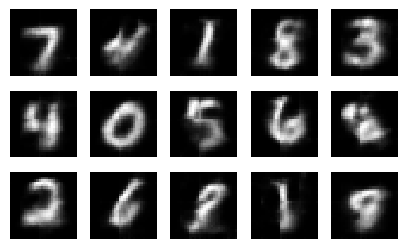

Visualizing encoded and decoded images:


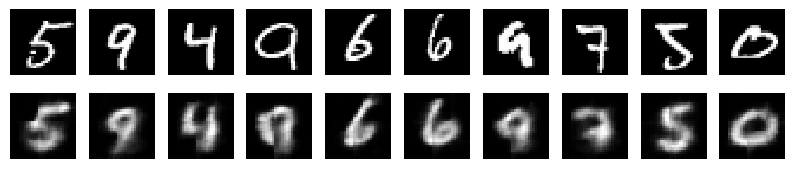

################################################################################
Epoch: 0011/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.67it/s]
training set errors:	classification error: 0.132055	autoencoder error: 0.038925	error_1: 0.712801	error_2: 1.523835	total error: 4.916668	accuracy: 0.968146
training takes 18.00 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]
validation set errors:	classification error: 0.070843	autoencoder error: 0.044587	error_1: 0.866647	error_2: 1.465275	total error: 3.793368	accuracy: 0.981417
################################################################################
Epoch: 0012/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.53it/s]
training set errors:	classification error: 0.111034	autoencoder error: 0.038832	error_1: 0.720740	error_2: 1.472028	total error: 4.452272	accuracy: 0.968688
training takes 18.24 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.74it/s]
validation set errors:	clas

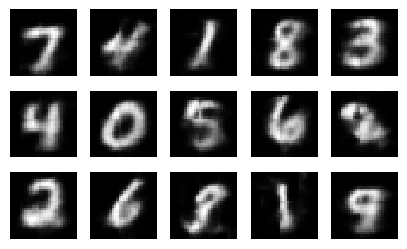

Visualizing encoded and decoded images:


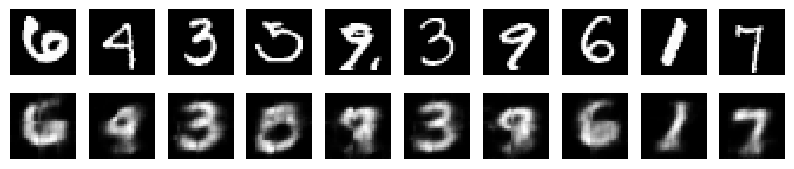

################################################################################
Epoch: 0016/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.41it/s]
training set errors:	classification error: 0.117737	autoencoder error: 0.038000	error_1: 0.613923	error_2: 1.426885	total error: 4.433555	accuracy: 0.970979
training takes 18.45 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.58it/s]
validation set errors:	classification error: 0.042433	autoencoder error: 0.044384	error_1: 0.633840	error_2: 1.290312	total error: 2.817202	accuracy: 0.982000
################################################################################
Epoch: 0017/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.38it/s]
training set errors:	classification error: 0.071245	autoencoder error: 0.038198	error_1: 0.560937	error_2: 1.300881	total error: 3.324920	accuracy: 0.973708
training takes 18.49 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 21.62it/s]
validation set errors:	clas

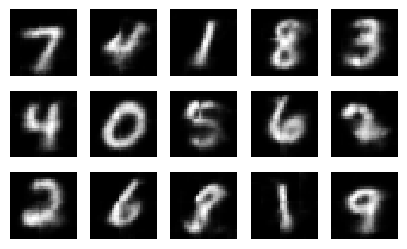

Visualizing encoded and decoded images:


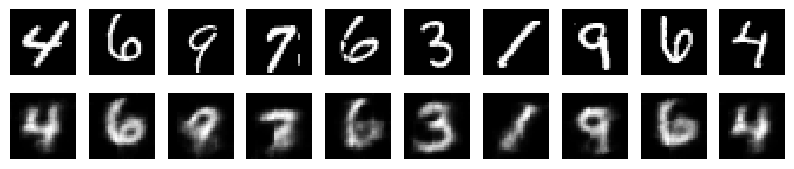

################################################################################
Epoch: 0021/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.28it/s]
training set errors:	classification error: 0.138941	autoencoder error: 0.039340	error_1: 0.506096	error_2: 1.292558	total error: 4.616818	accuracy: 0.976500
training takes 18.67 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.65it/s]
validation set errors:	classification error: 0.029226	autoencoder error: 0.043024	error_1: 0.444593	error_2: 1.092754	total error: 2.164881	accuracy: 0.982917
################################################################################
Epoch: 0022/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.28it/s]
training set errors:	classification error: 0.096092	autoencoder error: 0.038449	error_1: 0.416389	error_2: 1.222739	total error: 3.599426	accuracy: 0.975792
training takes 18.69 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.60it/s]
validation set errors:	clas

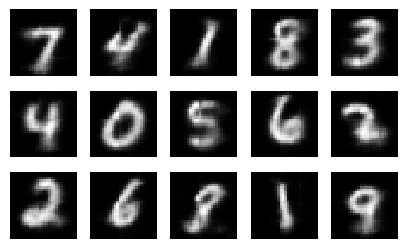

Visualizing encoded and decoded images:


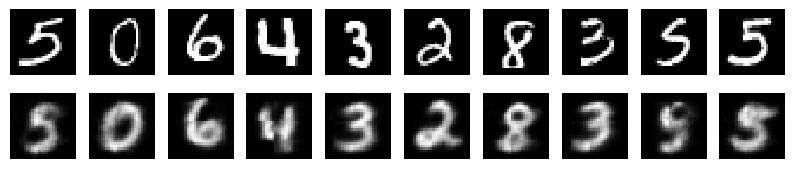

################################################################################
Epoch: 0026/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.14it/s]
training set errors:	classification error: 0.089161	autoencoder error: 0.038968	error_1: 0.457990	error_2: 1.184935	total error: 3.465113	accuracy: 0.978333
training takes 18.94 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.14it/s]
validation set errors:	classification error: 0.024599	autoencoder error: 0.043468	error_1: 0.396881	error_2: 1.025697	total error: 1.958034	accuracy: 0.985083
################################################################################
Epoch: 0027/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.20it/s]
training set errors:	classification error: 0.071173	autoencoder error: 0.038392	error_1: 0.439689	error_2: 1.207463	total error: 3.109006	accuracy: 0.977959
training takes 18.83 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.61it/s]
validation set errors:	clas

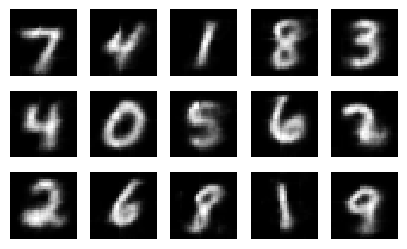

Visualizing encoded and decoded images:


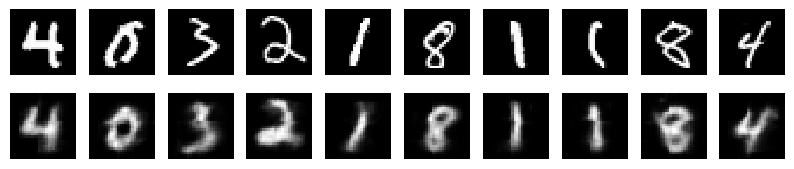

################################################################################
Epoch: 0031/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.16it/s]
training set errors:	classification error: 0.038827	autoencoder error: 0.039499	error_1: 0.334273	error_2: 1.096833	total error: 2.247153	accuracy: 0.978667
training takes 18.90 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.39it/s]
validation set errors:	classification error: 0.044528	autoencoder error: 0.045412	error_1: 0.389131	error_2: 1.085054	total error: 2.410165	accuracy: 0.986000
################################################################################
Epoch: 0032/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00, 10.04it/s]
training set errors:	classification error: 0.082994	autoencoder error: 0.037772	error_1: 0.323906	error_2: 1.062822	total error: 3.084371	accuracy: 0.978333
training takes 19.12 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.08it/s]
validation set errors:	clas

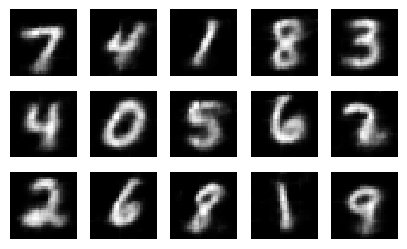

Visualizing encoded and decoded images:


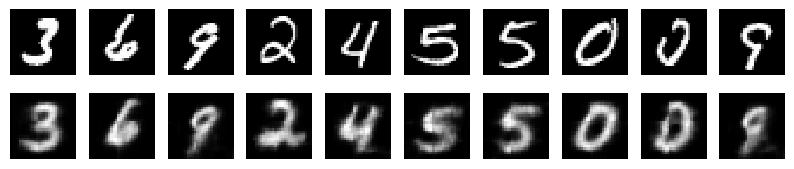

################################################################################
Epoch: 0036/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.74it/s]
training set errors:	classification error: 0.141609	autoencoder error: 0.037490	error_1: 0.278077	error_2: 1.078666	total error: 4.226408	accuracy: 0.979896
training takes 19.71 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.96it/s]
validation set errors:	classification error: 0.039782	autoencoder error: 0.042759	error_1: 0.291389	error_2: 0.938971	total error: 2.068752	accuracy: 0.985667
################################################################################
Epoch: 0037/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.85it/s]
training set errors:	classification error: 0.078732	autoencoder error: 0.038355	error_1: 0.314586	error_2: 1.075601	total error: 3.003182	accuracy: 0.979250
training takes 19.49 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.74it/s]
validation set errors:	clas

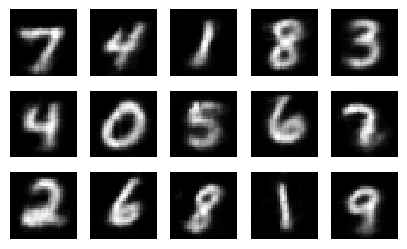

Visualizing encoded and decoded images:


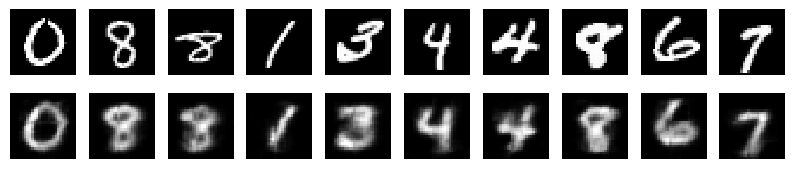

################################################################################
Epoch: 0041/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.65it/s]
training set errors:	classification error: 0.036495	autoencoder error: 0.038190	error_1: 0.296302	error_2: 1.052744	total error: 2.117143	accuracy: 0.979791
training takes 19.90 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]
validation set errors:	classification error: 0.071417	autoencoder error: 0.043484	error_1: 0.270237	error_2: 1.052960	total error: 2.795016	accuracy: 0.986750
################################################################################
Epoch: 0042/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.68it/s]
training set errors:	classification error: 0.071133	autoencoder error: 0.038415	error_1: 0.317717	error_2: 1.072198	total error: 2.850994	accuracy: 0.980479
training takes 19.84 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.63it/s]
validation set errors:	clas

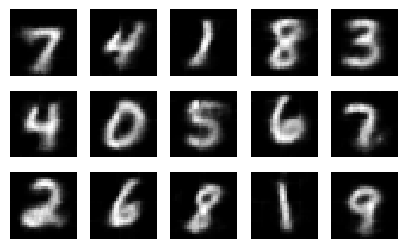

Visualizing encoded and decoded images:


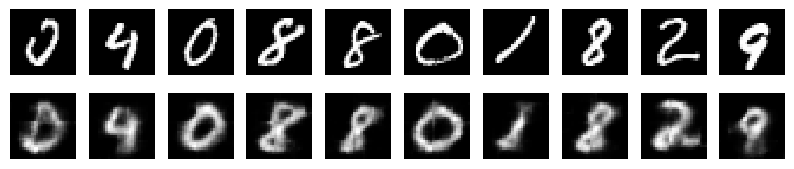

################################################################################
Epoch: 0046/0100
batch: 192: 100%|██████████| 192/192 [00:20<00:00,  9.45it/s]
training set errors:	classification error: 0.030698	autoencoder error: 0.038286	error_1: 0.303368	error_2: 0.947986	total error: 1.903597	accuracy: 0.981583
training takes 20.31 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.53it/s]
validation set errors:	classification error: 0.036709	autoencoder error: 0.045454	error_1: 0.293847	error_2: 0.925597	total error: 1.999081	accuracy: 0.987917
################################################################################
Epoch: 0047/0100
batch: 192: 100%|██████████| 192/192 [00:19<00:00,  9.61it/s]
training set errors:	classification error: 0.068285	autoencoder error: 0.036649	error_1: 0.263763	error_2: 1.034678	total error: 2.700791	accuracy: 0.981917
training takes 19.99 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 22.58it/s]
validation set errors:	clas

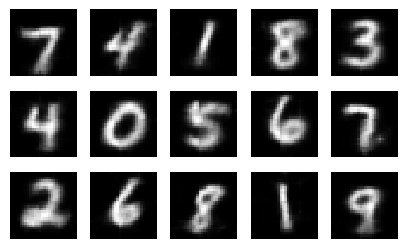

Visualizing encoded and decoded images:


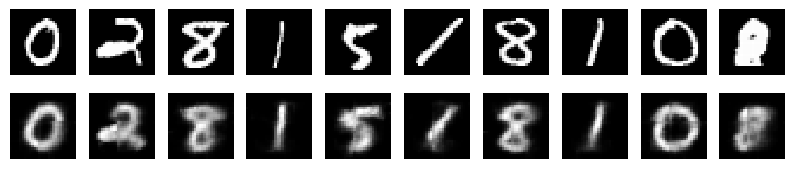

################################################################################
Epoch: 0051/0100
batch: 192: 100%|██████████| 192/192 [08:16<00:00,  2.59s/it]
training set errors:	classification error: 0.071463	autoencoder error: 0.037973	error_1: 0.227985	error_2: 0.999505	total error: 2.694728	accuracy: 0.981187
training takes 496.52 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.52it/s]
validation set errors:	classification error: 0.048855	autoencoder error: 0.045724	error_1: 0.262578	error_2: 0.922358	total error: 2.207758	accuracy: 0.988250
################################################################################
Epoch: 0052/0100
batch: 192: 100%|██████████| 192/192 [14:42<00:00,  4.59s/it]  
training set errors:	classification error: 0.096055	autoencoder error: 0.035489	error_1: 0.207264	error_2: 1.016967	total error: 3.180815	accuracy: 0.981229
training takes 882.06 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 27.57it/s]
validation set errors:	

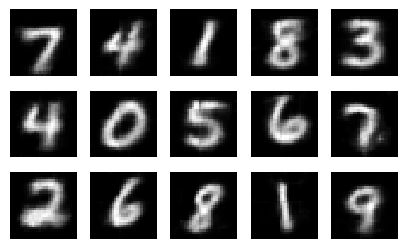

Visualizing encoded and decoded images:


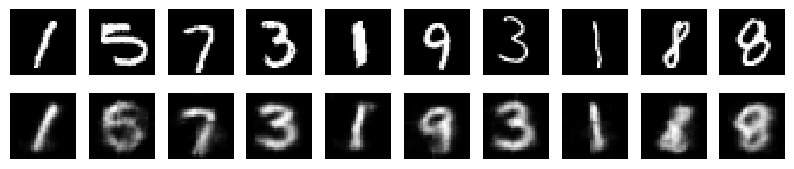

################################################################################
Epoch: 0056/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.73it/s]
training set errors:	classification error: 0.031734	autoencoder error: 0.039607	error_1: 0.216974	error_2: 0.945038	total error: 1.836300	accuracy: 0.982708
training takes 16.37 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.54it/s]
validation set errors:	classification error: 0.070947	autoencoder error: 0.044889	error_1: 0.227490	error_2: 0.854055	total error: 2.545378	accuracy: 0.988583
################################################################################
Epoch: 0057/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.81it/s]
training set errors:	classification error: 0.044415	autoencoder error: 0.038725	error_1: 0.253337	error_2: 1.036759	total error: 2.217128	accuracy: 0.981604
training takes 16.26 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 26.68it/s]
validation set errors:	clas

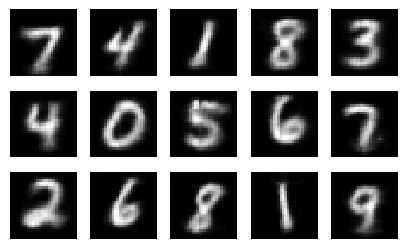

Visualizing encoded and decoded images:


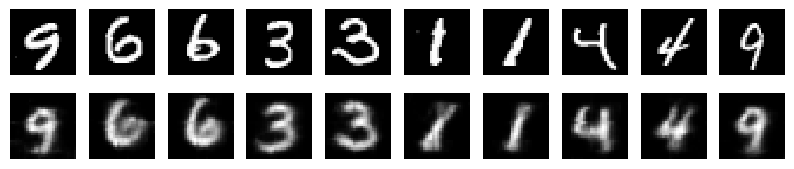

################################################################################
Epoch: 0061/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 11.01it/s]
training set errors:	classification error: 0.049992	autoencoder error: 0.037638	error_1: 0.224343	error_2: 0.967636	total error: 2.229462	accuracy: 0.982708
training takes 17.44 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.53it/s]
validation set errors:	classification error: 0.036245	autoencoder error: 0.044391	error_1: 0.206902	error_2: 0.821708	total error: 1.797908	accuracy: 0.989500
################################################################################
Epoch: 0062/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 11.00it/s]
training set errors:	classification error: 0.046503	autoencoder error: 0.038250	error_1: 0.286131	error_2: 0.987583	total error: 2.242025	accuracy: 0.982750
training takes 17.46 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.04it/s]
validation set errors:	clas

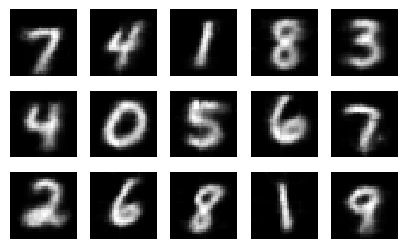

Visualizing encoded and decoded images:


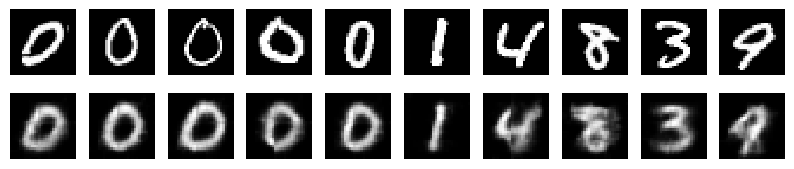

################################################################################
Epoch: 0066/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.89it/s]
training set errors:	classification error: 0.049180	autoencoder error: 0.038330	error_1: 0.169147	error_2: 0.947719	total error: 2.138802	accuracy: 0.982583
training takes 17.64 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.11it/s]
validation set errors:	classification error: 0.024304	autoencoder error: 0.042809	error_1: 0.216146	error_2: 0.760054	total error: 1.505089	accuracy: 0.988833
################################################################################
Epoch: 0067/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.82it/s]
training set errors:	classification error: 0.076717	autoencoder error: 0.037624	error_1: 0.196940	error_2: 0.888433	total error: 2.657332	accuracy: 0.983813
training takes 17.75 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.53it/s]
validation set errors:	clas

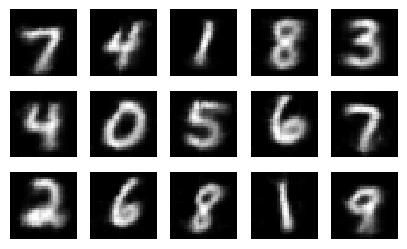

Visualizing encoded and decoded images:


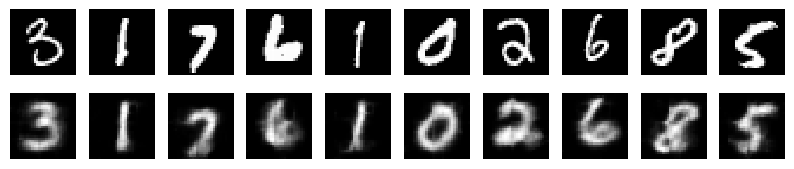

################################################################################
Epoch: 0071/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.37it/s]
training set errors:	classification error: 0.068643	autoencoder error: 0.038967	error_1: 0.192317	error_2: 1.026677	total error: 2.630814	accuracy: 0.983562
training takes 18.51 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.88it/s]
validation set errors:	classification error: 0.036199	autoencoder error: 0.044653	error_1: 0.197346	error_2: 0.865174	total error: 1.831148	accuracy: 0.988084
################################################################################
Epoch: 0072/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.49it/s]
training set errors:	classification error: 0.048257	autoencoder error: 0.038299	error_1: 0.180575	error_2: 0.907456	total error: 2.091464	accuracy: 0.983646
training takes 18.30 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.89it/s]
validation set errors:	clas

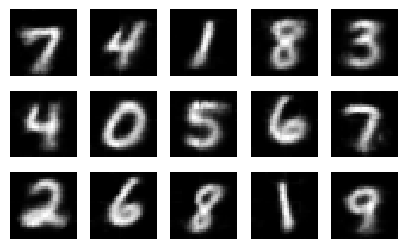

Visualizing encoded and decoded images:


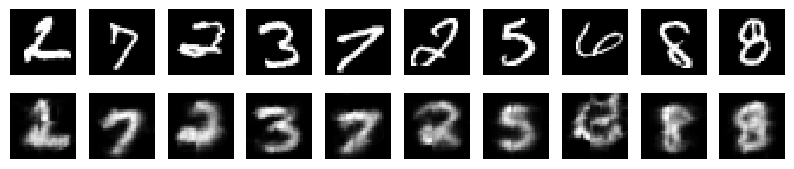

################################################################################
Epoch: 0076/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.77it/s]
training set errors:	classification error: 0.070586	autoencoder error: 0.037861	error_1: 0.198908	error_2: 0.940916	total error: 2.589404	accuracy: 0.983292
training takes 17.82 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.13it/s]
validation set errors:	classification error: 0.053618	autoencoder error: 0.042567	error_1: 0.197924	error_2: 0.857480	total error: 2.170336	accuracy: 0.988666
################################################################################
Epoch: 0077/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.64it/s]
training set errors:	classification error: 0.059893	autoencoder error: 0.038996	error_1: 0.161148	error_2: 0.878513	total error: 2.276518	accuracy: 0.983042
training takes 18.04 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.13it/s]
validation set errors:	clas

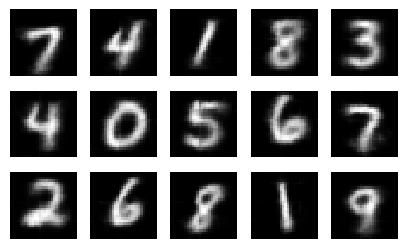

Visualizing encoded and decoded images:


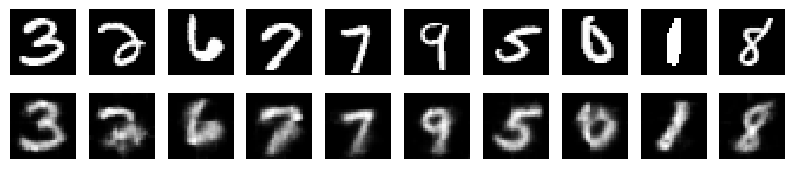

################################################################################
Epoch: 0081/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.75it/s]
training set errors:	classification error: 0.055980	autoencoder error: 0.037813	error_1: 0.173068	error_2: 0.954867	total error: 2.285351	accuracy: 0.983958
training takes 17.86 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.83it/s]
validation set errors:	classification error: 0.059364	autoencoder error: 0.045769	error_1: 0.229157	error_2: 0.823337	total error: 2.285545	accuracy: 0.988417
################################################################################
Epoch: 0082/0100
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 10.77it/s]
training set errors:	classification error: 0.059526	autoencoder error: 0.040681	error_1: 0.180585	error_2: 0.958277	total error: 2.370058	accuracy: 0.983187
training takes 17.83 seconds.
batch: 048: 100%|██████████| 48/48 [00:02<00:00, 23.83it/s]
validation set errors:	clas

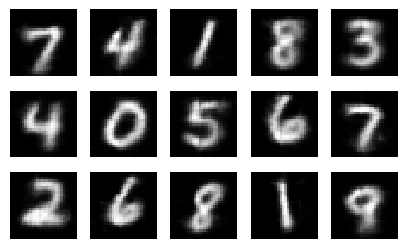

Visualizing encoded and decoded images:


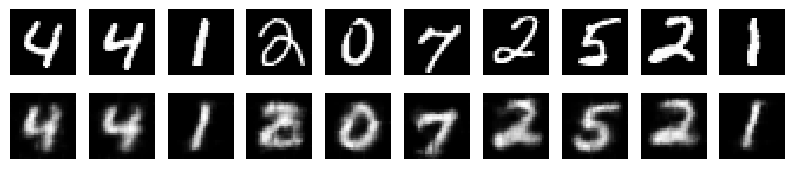

################################################################################
Epoch: 0086/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.60it/s]
training set errors:	classification error: 0.041493	autoencoder error: 0.036847	error_1: 0.174145	error_2: 0.886553	total error: 1.927400	accuracy: 0.984917
training takes 18.11 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.94it/s]
validation set errors:	classification error: 0.010245	autoencoder error: 0.044006	error_1: 0.182638	error_2: 0.777871	total error: 1.209416	accuracy: 0.989167
################################################################################
Epoch: 0087/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.63it/s]
training set errors:	classification error: 0.044850	autoencoder error: 0.037737	error_1: 0.183484	error_2: 0.870026	total error: 1.988253	accuracy: 0.984333
training takes 18.06 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.39it/s]
validation set errors:	clas

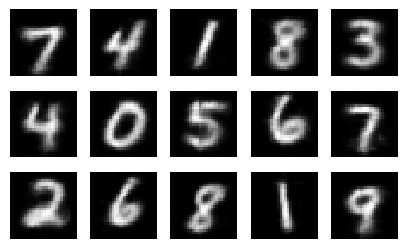

Visualizing encoded and decoded images:


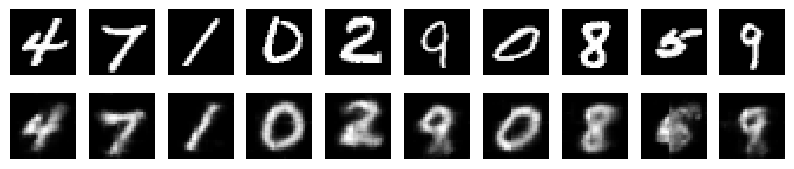

################################################################################
Epoch: 0091/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.57it/s]
training set errors:	classification error: 0.048913	autoencoder error: 0.037118	error_1: 0.171568	error_2: 0.892375	total error: 2.079328	accuracy: 0.984583
training takes 18.16 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.46it/s]
validation set errors:	classification error: 0.107097	autoencoder error: 0.045172	error_1: 0.340417	error_2: 0.888474	total error: 3.416002	accuracy: 0.988500
################################################################################
Epoch: 0092/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.62it/s]
training set errors:	classification error: 0.024880	autoencoder error: 0.037200	error_1: 0.177272	error_2: 0.820283	total error: 1.532352	accuracy: 0.985146
training takes 18.08 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.68it/s]
validation set errors:	clas

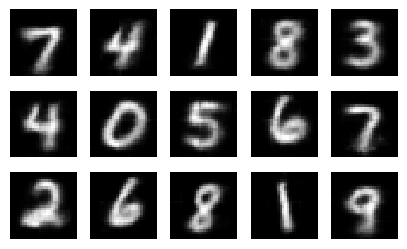

Visualizing encoded and decoded images:


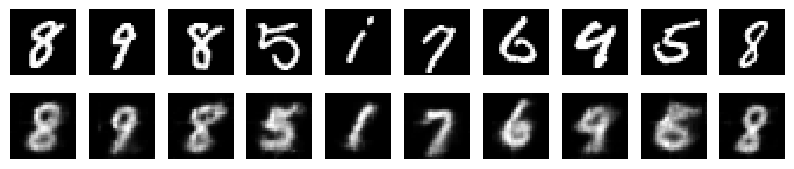

################################################################################
Epoch: 0096/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.60it/s]
training set errors:	classification error: 0.031458	autoencoder error: 0.037548	error_1: 0.175496	error_2: 0.810417	total error: 1.652629	accuracy: 0.983938
training takes 18.12 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.79it/s]
validation set errors:	classification error: 0.047931	autoencoder error: 0.042467	error_1: 0.185641	error_2: 0.678904	total error: 1.865632	accuracy: 0.987917
################################################################################
Epoch: 0097/0100
batch: 192: 100%|██████████| 192/192 [00:18<00:00, 10.63it/s]
training set errors:	classification error: 0.068428	autoencoder error: 0.037052	error_1: 0.188824	error_2: 0.871911	total error: 2.466342	accuracy: 0.984063
training takes 18.07 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 24.17it/s]
validation set errors:	clas

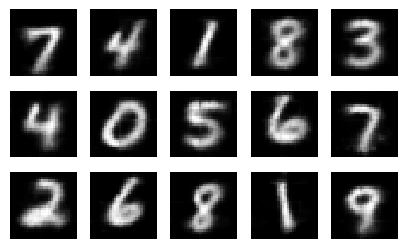

Visualizing encoded and decoded images:


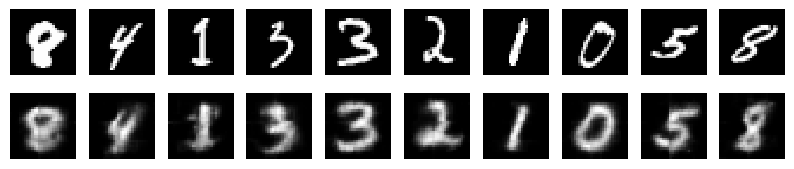

Total taken time 5915.76 seconds.
Optimization Finished!


In [40]:
from tqdm import tqdm, tqdm_notebook

start_time= time.time()

# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1)+"/%04d" % (training_epochs), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # softmax crossentropy loss
            loss_function = torch.nn.CrossEntropyLoss()
            train_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            train_ae = torch.mean(list_of_norms(out_decoder-elastic_batch_x))

            train_te = lambda_class * train_ce +\
                    lambda_1 * train_e1 +\
                    lambda_2 * train_e2 +\
                    lambda_ae * train_ae

            train_te.backward()

            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
    
    train_ac /= n_train_batch
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    val_ce, val_ae, val_e1, val_e2, val_te, val_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(val_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            loss_function = torch.nn.CrossEntropyLoss()
            val_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            val_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            val_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            val_ae = torch.mean(list_of_norms(out_decoder-batch_x))

            val_te = lambda_class * val_ce +\
                    lambda_1 * val_e1 +\
                    lambda_2 * val_e2 +\
                    lambda_ae * val_ae
            # validation accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
           
    val_ac /= n_val_batch
    # after every epoch, check the error terms on the entire training set
    print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                    "\tautoencoder error: {:.6f}".format(val_ae)+
                    "\terror_1: {:.6f}".format(val_e1)+
                    "\terror_2: {:.6f}".format(val_e2)+
                    "\ttotal error: {:.6f}".format(val_te)+
                    "\taccuracy: {:.6f}".format(val_ac), console_log)
    
    # test set accuracy evaluation
    if (epoch+1) % test_display_step == 0 or epoch == training_epochs - 1:
        test_ac = 0

        for i, batch in enumerate(test_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            # test accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            test_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        test_ac /= n_test_batch

        print_and_write("test set:", console_log)
        print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        model_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch+1}
        torch.save(model_state, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))

        # save outputs as images
        # decode prototype vectors
        prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

        # visualize the prototype images
        print_and_write("Visualizing the prototype images:", console_log)
        n_cols = 5
        n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
        g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                if i*n_cols + j < n_prototypes:
                    b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
                    b[i][j].axis('off')
                    
        plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.close()

        # apply encoding and decoding over a small subset of the training set
        print_and_write("Visualizing encoded and decoded images:", console_log)
        batch_x = []
        for batch in train_loader:
            batch_x = batch[0].to(device)
            break

        examples_to_show = 10
        
        encoded = model.encoder.forward(batch_x[:examples_to_show])
        decoded = model.decoder.forward(encoded)

        decoded = decoded.detach().cpu()
        imgs = batch_x.detach().cpu()

        # compare original images to their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            a[0][i].axis('off')
            a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
            a[1][i].axis('off')
            
        plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                    transparent=True,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()
        
print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()

### loop iras

In [92]:
def generalLoss(model, batch_x, batch_y, pred_y, lambda_class, lambda_1, lambda_2, lambda_ae, batch_x_ori=None):
    
    loss_function = torch.nn.CrossEntropyLoss()
    train_ce = loss_function(pred_y, batch_y)

    prototype_distances = model.prototype_layer.prototype_distances
    feature_vectors = model.feature_vectors

    if lambda_1 == 0:
        train_e1 = 0
    else:
        train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
    
    train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])
    
    out_decoder = model.decoder(feature_vectors)
    
    if batch_x_ori is None:
        train_ae = torch.mean(list_of_norms(out_decoder-batch_x))
    else:
        train_ae = torch.mean(list_of_norms(out_decoder-batch_x_ori))
    
    train_ae = torch.mean(list_of_norms(out_decoder-batch_x))

    train_te = lambda_class * train_ce +\
            lambda_1 * train_e1 +\
            lambda_2 * train_e2 +\
            lambda_ae * train_ae
    
    return train_te, train_ce, train_e1, train_e2, train_ae

In [94]:
optimizer_filename = "optimizer.pth"
validation_display_step = 100 

In [95]:
# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    model.train() # CHANGED !!!

    
    train_ce, train_ae, train_e1, train_e2, train_te, train_ac, train_clst_l, train_sep_l = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            #print(model.prototype_layer.prototype_distances[0])
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # loss CHANGED !!!
            
            train_te, train_ce, train_e1, train_e2, train_ae = generalLoss(model, elastic_batch_x, batch_y, pred_y, lambda_class, lambda_1, lambda_2, lambda_ae)
            
            train_te.backward()
        
            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)            
    
    train_ac /= n_train_batch
    
    # after every epoch, check the error terms on the entire training set
    
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    if (epoch+1) % validation_display_step == 0 or epoch == training_epochs - 1:
        
        val_ce, val_ae, val_e1, val_e2, val_te, val_ac, val_clst_l, val_sep_l = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        
        model.eval()
        with torch.no_grad():
            
            for i, batch in enumerate(val_loader):
                batch_x = batch[0]
                batch_y = batch[1]
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                pred_y = model.forward(batch_x)

                #loss
                
                val_te, val_ce, val_e1, val_e2, val_ae = generalLoss(model, batch_x, batch_y, pred_y, lambda_class, lambda_1, lambda_2, lambda_ae)
                 
                # validation accuracy
                max_vals, max_indices = torch.max(pred_y,1)
                n = max_indices.size(0)
                val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        val_ac /= n_val_batch

        # after every epoch, check the error terms on the entire training set
        
        print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                        "\tautoencoder error: {:.6f}".format(val_ae)+
                        "\terror_1: {:.6f}".format(val_e1)+
                        "\terror_2: {:.6f}".format(val_e2)+
                        "\ttotal error: {:.6f}".format(val_te)+
                        "\taccuracy: {:.6f}".format(val_ac), console_log)
        
    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        torch.save(model, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))
        torch.save(optimizer, os.path.join(model_folder, optimizer_filename+'%05d.pth' % (epoch+1)))

        model.eval()
        with torch.no_grad():
            
            # save outputs as images
            # decode prototype vectors
            prototype_distances = model.prototype_layer.prototype_distances
            prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

            # visualize the prototype images
            n_cols = 5
            n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
            g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
            for i in range(n_rows):
                for j in range(n_cols):
                    if i*n_cols + j < n_prototypes:
                        b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                        cmap='gray',
                                        interpolation='none')
                        b[i][j].axis('off')
                        
            plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                        transparent=True, bbox_inches='tight', pad_inches=0)
            plt.close()

            # apply encoding and decoding over a small subset of the training set
            batch_x = []
            for batch in train_loader:
                batch_x = batch[0].to(device)
                break

            examples_to_show = 10
            
            encoded = model.encoder.forward(batch_x[:examples_to_show])
            decoded = model.decoder.forward(encoded)

            decoded = decoded.detach().cpu()
            imgs = batch_x.detach().cpu()

            # compare original images to their reconstructions
            f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
            for i in range(examples_to_show):
                a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                                cmap='gray',
                                interpolation='none')
                a[0][i].axis('off')
                a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                                cmap='gray',
                                interpolation='none')
                a[1][i].axis('off')
                
            plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                        transparent=True,
                        bbox_inches='tight',
                        pad_inches=0)
            plt.close()

print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()


################################################################################
Epoch: 0001
batch: 002:   1%|          | 1/192 [00:00<00:23,  7.97it/s]

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_10378/1429368971.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  e_images[:] = images


batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.55it/s]
training set errors:	classification error: 7.595806	autoencoder error: 0.263591	error_1: 12.554121	error_2: 9.294888	total error: 174.028732	accuracy: 0.101958
training takes 16.63 seconds.
################################################################################
Epoch: 0002
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.40it/s]
training set errors:	classification error: 6.897065	autoencoder error: 0.262872	error_1: 12.553480	error_2: 9.293204	total error: 160.050858	accuracy: 0.101958
training takes 16.85 seconds.
################################################################################
Epoch: 0003
batch: 192: 100%|██████████| 192/192 [00:17<00:00, 11.25it/s]
training set errors:	classification error: 7.095177	autoencoder error: 0.262884	error_1: 12.554343	error_2: 9.295322	total error: 164.016083	accuracy: 0.101958
training takes 17.06 seconds.
##########################################################

## analisis

In [5]:
paths = {"B30": "./saved_model copia/mnist_model/mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1/mnist_cae00750.pth",
         "S30": "./saved_model copia/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1/mnist_cae00750.pth",
         "S15": "./saved_model copia/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth",
         "RS30": "./saved_model copia/mnist_model/mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "RB30": "./saved_model copia/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth",
         "FTB30n": "./saved_model copia/mnist_model/mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30a": "./saved_model copia/mnist_model/mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth",
         "FTB30p": "./saved_model copia/mnist_model/mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1/mnist_cae_adv00020.pth"}

s15 = torch.load(paths["S15"], weights_only=False)
s30 = torch.load(paths["S30"], weights_only=False)
b30 = torch.load(paths["B30"], weights_only=False)
#rs30 = torch.load(paths["RS30"], weights_only=False)
#rb30 = torch.load(paths["RB30"], weights_only=False)
#ftb30n = torch.load(paths["FTB30n"], weights_only=False)
#ftb30a = torch.load(paths["FTB30a"], weights_only=False)
#ftb30p = torch.load(paths["FTB30p"], weights_only=False)

s15.to(device)
s30.to(device)
b30.to(device)
#rs30.to(device)
#rb30.to(device)
#ftb30a.to(device)
#ftb30n.to(device)
#ftb30p.to(device)

print("MODELS LOADED")

ModuleNotFoundError: No module named 'modules'

In [24]:
n_classes = s15_model.fc.linear.weight.size(0)
n_prototypes = s15_model.fc.linear.weight.size(1)
input_height = 28         # MNIST data input shape
input_width = input_height

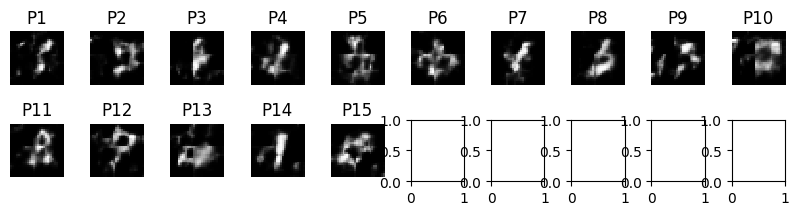

In [27]:
# visualize the prototype images
prototype_distances = s15_model.prototype_layer.prototype_distances
prototype_imgs = s15_model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

n_cols = 10
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

# Ajuste del espacio entre subgráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            b[i][j].axis('off')
            b[i][j].set_title(f'P{i*n_cols + j + 1}')
plt.show()

In [23]:
paths = {"B30": "saved_model copia/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth"}

B30 = torch.load(paths["B30"], weights_only=False)

ModuleNotFoundError: No module named 'modules'

In [22]:
paths = {"S15": "saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth"}

s15 = torch.load(paths["S15"], weights_only=False)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model/mnist_model/mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1/mnist_cae00750.pth'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paths = {"B30": "./saved_model copia/mnist_model/mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1/mnist_cae_adv00750.pth"}

B30 = torch.load(paths["B30"], weights_only=False)
B30_model = CAEModel().to(device)
checkpoint = torch.load(paths["B30"], map_location="cpu")
B30_model.load_state_dict(checkpoint["model"])
B30_model.to(device)
# model = s15_model
n_prototypes = B30_model.prototype_layer.prototype_distances.size(0)

ModuleNotFoundError: No module named 'modules'

### Prototipos aprendidos S15

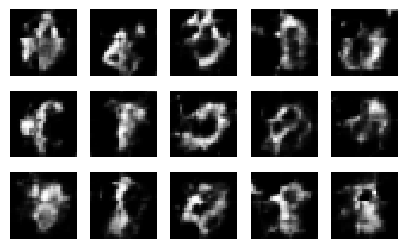

In [ ]:
# decode prototype vectors
prototype_imgs = B30_model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

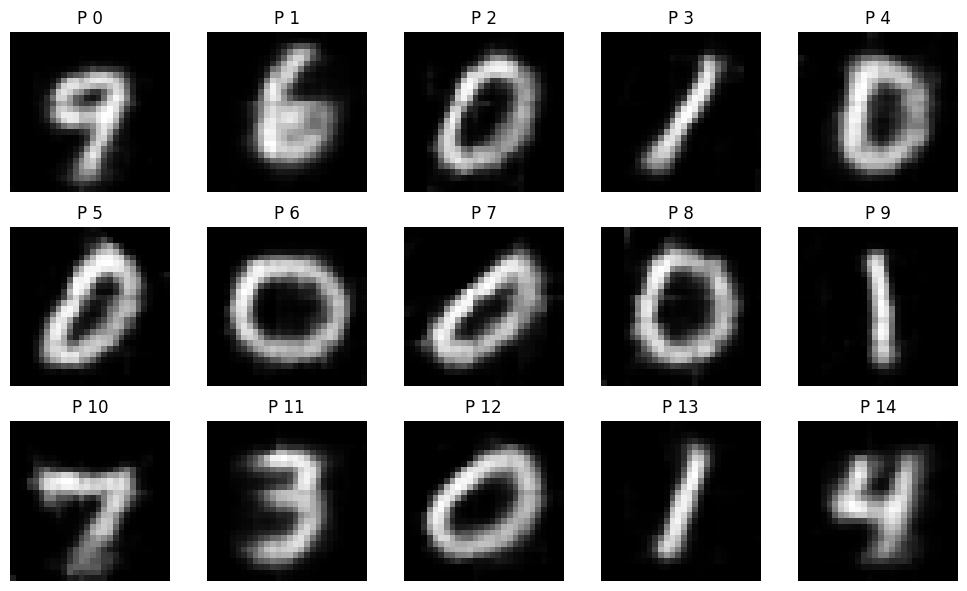

In [48]:
import matplotlib.pyplot as plt
import torch

# Asegurar que los prototipos están en CPU y convertir a numpy
prototype_imgs_np = prototype_imgs.squeeze().detach().cpu().numpy()

# Parámetros de la cuadrícula
n_prototypes = prototype_imgs_np.shape[0]
n_cols = 5
n_rows = (n_prototypes // n_cols) + (1 if n_prototypes % n_cols != 0 else 0)

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < n_prototypes:
        ax.imshow(prototype_imgs_np[i], cmap='gray', interpolation='none')
        ax.set_title(f"P {i}")  # Puedes cambiar el título si quieres agregar más info
        #ax.set_title(f"Clase {prototype_classes[i].item()}")

        ax.axis("off")

    else:
        ax.axis("off")  # Apagar ejes para celdas vacías

plt.tight_layout()
plt.show()


In [49]:
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break

# Paso 1: Encontrar el índice de la imagen más cercana a cada prototipo
closest_train_example = prototype_distances.argmin(dim=1)  # Índice del ejemplo de entrenamiento más cercano

# Paso 2: Asignar la clase de ese ejemplo al prototipo
prototype_classes = batch_y[closest_train_example]  # Clases asociadas a cada prototipo

# Mostramos la asociación prototipo → clase
for i, cls in enumerate(prototype_classes):
    print(f"Prototipo {i} → Clase asignada: {cls.item()}")


Prototipo 0 → Clase asignada: 0
Prototipo 1 → Clase asignada: 1
Prototipo 2 → Clase asignada: 8
Prototipo 3 → Clase asignada: 4
Prototipo 4 → Clase asignada: 4
Prototipo 5 → Clase asignada: 3
Prototipo 6 → Clase asignada: 8
Prototipo 7 → Clase asignada: 4
Prototipo 8 → Clase asignada: 2
Prototipo 9 → Clase asignada: 9
Prototipo 10 → Clase asignada: 6
Prototipo 11 → Clase asignada: 0
Prototipo 12 → Clase asignada: 5
Prototipo 13 → Clase asignada: 2
Prototipo 14 → Clase asignada: 8


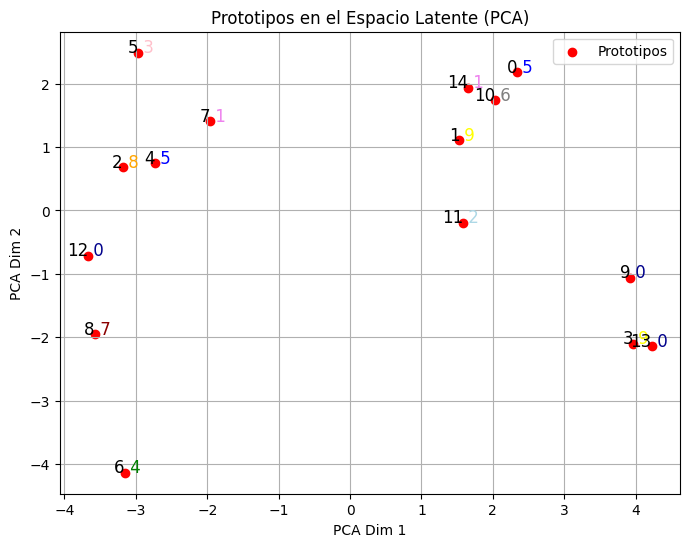

In [50]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_prototypes = prototype_imgs.shape[0]
flattened_prototypes = prototype_imgs.view(n_prototypes, -1).numpy()  # (15, 784)

pca = PCA(n_components=2)
prototype_coords = pca.fit_transform(flattened_prototypes)  # (15, 2)

plt.figure(figsize=(8, 6))
plt.scatter(prototype_coords[:, 0], prototype_coords[:, 1], c="red", marker="o", label="Prototipos")

for i, (x, y) in enumerate(prototype_coords):
    plt.text(x, y, str(i), fontsize=12, ha='right', color="black")
    if i == 0 or i == 4:
        plt.text(x, y, " 5", fontsize=12, ha='left', color="blue")
    elif i == 1 or i ==3:
        plt.text(x, y, " 9", fontsize=12, ha='left', color="yellow")
    elif i == 2:
        plt.text(x, y, " 8", fontsize=12, ha='left', color="orange")
    elif i == 5:
        plt.text(x, y, " 3", fontsize=12, ha='left', color="pink")
    elif i == 6:
        plt.text(x, y, " 4", fontsize=12, ha='left', color="green")
    elif i == 7 or i == 14:
        plt.text(x, y, " 1", fontsize=12, ha='left', color="violet")
    elif i == 8:
        plt.text(x, y, " 7", fontsize=12, ha='left', color="darkred")
    elif i == 9 or i == 12 or i == 13:
        plt.text(x, y, " 0", fontsize=12, ha='left', color="darkblue")
    elif i == 10:
        plt.text(x, y, " 6", fontsize=12, ha='left', color="grey")
    elif i == 11:
        plt.text(x, y, " 2", fontsize=12, ha='left', color="lightblue")


plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.title("Prototipos en el Espacio Latente (PCA)")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
import torch
from collections import defaultdict

# Función para encontrar la relación prototipo-clase
def analyze_prototype_class_relationship(model, data_loader, device, n_prototypes):
    model.eval()  # Modo evaluación
    prototype_class_counts = defaultdict(lambda: defaultdict(int))  # Diccionario para contar asociaciones
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            # Obtener las distancias a los prototipos
            _ = model.forward(batch_x)  # Ejecutar forward para calcular feature_vectors y prototype_distances
            prototype_distances = model.prototype_layer.prototype_distances  # Forma: (batch_size, n_prototypes)
            
            # Encontrar el prototipo más cercano para cada imagen
            min_distances, closest_prototypes = torch.min(prototype_distances, dim=1)  # Índices de prototipos más cercanos
            
            # Asociar cada prototipo con su clase
            for i, closest_prototype in enumerate(closest_prototypes):
                class_label = batch_y[i].item()  # Etiqueta de la clase (0-9 para MNIST)
                prototype_class_counts[closest_prototype.item()][class_label] += 1
    
    # Determinar la clase dominante por prototipo
    prototype_to_class = {}
    for proto_idx in range(n_prototypes):
        class_counts = prototype_class_counts[proto_idx]
        if class_counts:
            dominant_class = max(class_counts, key=class_counts.get)  # Clase con más asociaciones
            total_counts = sum(class_counts.values())
            percentage = (class_counts[dominant_class] / total_counts) * 100
            prototype_to_class[proto_idx] = (dominant_class, percentage)
            print(f"Prototipo {proto_idx}: Clase dominante = {dominant_class}, "
                  f"Porcentaje = {percentage:.2f}% ({class_counts[dominant_class]}/{total_counts})")
        else:
            print(f"Prototipo {proto_idx}: No asignado (sin muestras cercanas)")
    
    return prototype_to_class

n_prototypes = 15 # Número de prototipos
prototype_class_map = analyze_prototype_class_relationship(model, val_loader, device, n_prototypes)


Prototipo 0: No asignado (sin muestras cercanas)
Prototipo 1: Clase dominante = 4, Porcentaje = 14.58% (7/48)
Prototipo 2: Clase dominante = 8, Porcentaje = 14.58% (7/48)
Prototipo 3: No asignado (sin muestras cercanas)
Prototipo 4: Clase dominante = 7, Porcentaje = 14.58% (7/48)
Prototipo 5: Clase dominante = 5, Porcentaje = 20.83% (10/48)
Prototipo 6: No asignado (sin muestras cercanas)
Prototipo 7: No asignado (sin muestras cercanas)
Prototipo 8: Clase dominante = 4, Porcentaje = 12.50% (6/48)
Prototipo 9: No asignado (sin muestras cercanas)
Prototipo 10: No asignado (sin muestras cercanas)
Prototipo 11: No asignado (sin muestras cercanas)
Prototipo 12: Clase dominante = 6, Porcentaje = 14.58% (14/96)
Prototipo 13: No asignado (sin muestras cercanas)
Prototipo 14: No asignado (sin muestras cercanas)


In [30]:
print("Forma de prototype_distances:", prototype_distances.shape)
print("Valores de muestra:", prototype_distances[:5, :5])

Forma de prototype_distances: torch.Size([15, 40])
Valores de muestra: tensor([[0.2012, 0.9501, 0.3229, 0.9015, 0.5490],
        [0.9611, 0.4410, 0.6246, 0.0515, 0.2917],
        [0.8091, 0.5734, 0.4700, 0.6346, 0.7894],
        [0.9363, 0.9346, 0.2860, 0.5747, 0.4819],
        [0.7019, 0.4522, 0.4928, 0.5575, 0.4587]], grad_fn=<SliceBackward0>)


### Imágenes reales y su reconstrucción

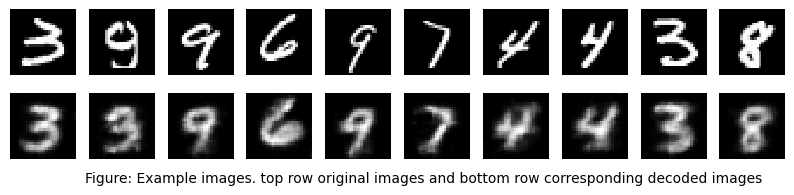

In [31]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()


# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')

f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()

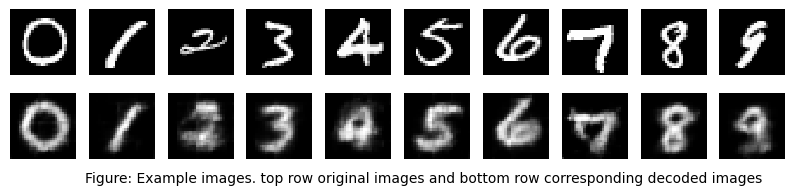

,0,1,2,3,4,5,6,7,8,9
0,13.433386,1.345191,-0.932652,-16.532045,-2.955891,-7.675024,2.293211,2.722359,-8.357660,0.649397
1,-2.608446,12.713671,2.444038,-11.753173,1.803774,-5.512739,1.472533,-2.334273,-8.540913,-3.695723
2,-3.042276,1.885143,7.098160,-0.932036,-4.679018,0.759330,-4.647973,0.774617,-4.271090,-5.416687
3,-10.359700,-2.335621,-1.198942,11.500720,-8.100833,2.484607,-12.349929,3.047152,-4.327744,-0.888066
4,-2.254610,-0.733999,2.715056,-11.135718,10.568251,-1.854653,-0.145376,-3.261465,-1.487176,-1.860523
5,-9.050589,-1.131117,-1.299891,1.709680,-4.515154,11.661839,-2.942884,-1.850631,-2.314957,-4.019561
6,1.178431,-4.370578,0.324489,-4.595445,-0.695552,1.775578,16.114845,-14.278612,7.296407,-4.059496
7,1.251110,-1.751505,-14.981788,-21.155884,7.717855,-14.421412,-16.862814,16.619156,-6.128777,6.696209
8,-0.320189,-6.608308,-3.175489,-4.934737,-2.210216,-5.362971,5.294716,-10.139575,16.059008,3.619828
9,-1.279641,-2.233761,-12.181507,-3.990130,0.898290,-2.050987,-3.096241,-1.732936,0.593490,9.499985


In [32]:
import pandas as pd
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break
    
pred_y = model.forward(batch_x)

pred_y_np = pred_y.detach().cpu().numpy() 
batch_y_np = batch_y.detach().cpu().numpy()
labels = []
data = []
idx = []
i = 0
j = 0
for l in batch_y_np:
    if(i==10):
        break
    if l==i:
        labels.append(l)
        data.append(pred_y_np[j])
        idx.append(j)
        i = i+1
    j = j + 1
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
examples_to_show = 10
        
encoded = model.encoder.forward(batch_x)
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu() 

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
j = 0
for i in idx:
    a[0][j].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][j].axis('off')
    a[1][j].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][j].axis('off')
    j = j + 1
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
plt.show()
plt.close()
    
df = pd.DataFrame(data, labels, classes)
df.style.format(precision=2)
df.style.highlight_max(props='background-color:red;color:white;', axis=1)




# Examples of test

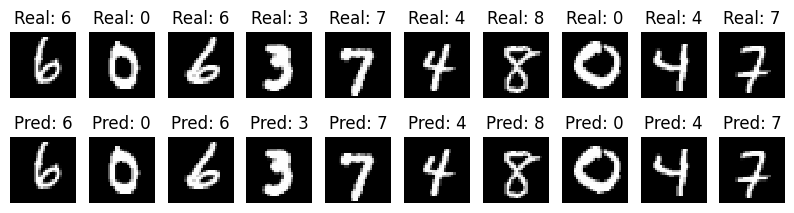

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999944,0.000000,0.000055,0.000000
Example 1,0.998707,0.000003,0.001161,0.000000,0.000001,0.000002,0.000032,0.000024,0.000070,0.000002
Example 2,0.000002,0.000000,0.000000,0.000000,0.000000,0.000008,0.999971,0.000000,0.000019,0.000000
Example 3,0.000000,0.000076,0.000010,0.995884,0.000000,0.001540,0.000000,0.001504,0.000013,0.000973
Example 4,0.000000,0.000007,0.000021,0.000268,0.000000,0.000002,0.000000,0.999701,0.000000,0.000002
Example 5,0.000000,0.000000,0.000000,0.000000,0.999998,0.000001,0.000000,0.000000,0.000000,0.000000
Example 6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000062,0.000000,0.999937,0.000000
Example 7,0.999916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000080,0.000003,0.000000,0.000002
Example 8,0.000000,0.000001,0.000000,0.000000,0.999582,0.000324,0.000000,0.000049,0.000001,0.000043
Example 9,0.000000,0.000481,0.000005,0.000620,0.000294,0.000074,0.000000,0.998294,0.000000,0.000232


In [33]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

with torch.no_grad():
    pred_y = model(batch_x) 

pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2.5))

for i in range(examples_to_show):
    # imagen original
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # clase predicha
    predicted_class = pred_y_np[i].argmax()
    axes[1, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f" \nPred: {predicted_class}")

plt.show()

df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])

df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df

#with torch.no_grad():
#    pred_y = model(batch_x)
#    prototype_distances = model.prototype_layer.prototype_distances
#    print("Distancias a prototipos (primeras 5 imágenes):", prototype_distances[:5])


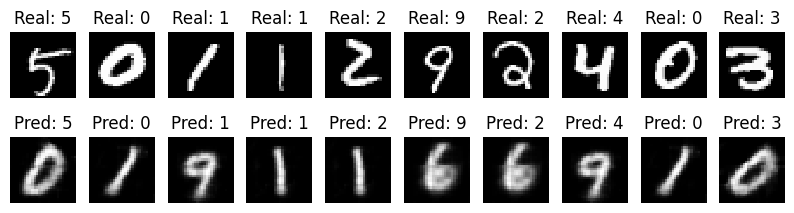

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000000,0.000000,0.000000,0.000001,0.000025,0.999942,0.000001,0.000001,0.000001,0.000029
Example 1,0.999982,0.000000,0.000005,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000012
Example 2,0.000000,0.999997,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Example 3,0.000000,0.999990,0.000003,0.000000,0.000004,0.000000,0.000000,0.000000,0.000002,0.000001
Example 4,0.000023,0.000659,0.995319,0.001593,0.000001,0.000144,0.000002,0.000194,0.002063,0.000002
Example 5,0.000000,0.000000,0.000000,0.000000,0.000026,0.000000,0.000000,0.000002,0.000206,0.999766
Example 6,0.000011,0.000022,0.999498,0.000260,0.000000,0.000003,0.000000,0.000191,0.000014,0.000000
Example 7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Example 8,0.999369,0.000040,0.000193,0.000000,0.000010,0.000000,0.000154,0.000033,0.000123,0.000078
Example 9,0.000000,0.000012,0.000150,0.996985,0.000000,0.000922,0.000000,0.001645,0.000208,0.000078


In [34]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Obtener un batch de test
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Obtener un batch del conjunto de test
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

# Hacer predicciones
with torch.no_grad():
    pred_y = model(batch_x)  # No usar forward() directamente

# Convertir a numpy para análisis
pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

# Obtener probabilidades con softmax
probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

# Seleccionar ejemplos a mostrar
examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2.5))

for i in range(examples_to_show):
    # Mostrar imagen original en la primera fila
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # Obtener la clase predicha
    predicted_class = pred_y_np[i].argmax()

    
    closest_train_example = prototype_distances.argmin(dim=1)  # Índice del ejemplo de entrenamiento más cercano

    # Paso 2: Asignar la clase de ese ejemplo al prototipo
    prototype_classes = batch_y[closest_train_example]

    # Obtener el prototipo más cercano a la clase predicha
    prototype_image = prototype_imgs[prototype_classes].cpu().squeeze()



    # Mostrar el prototipo en la segunda fila
    axes[1, i].imshow(prototype_image[i], cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Pred: {predicted_class}")

plt.show()

# Crear un DataFrame con probabilidades
df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])

# Resaltar las predicciones más altas
df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df


# Attacks

## Class Attack
https://github.com/Harry24k/adversarial-attacks-pytorch/tree/master/torchattacks

In [35]:
import time
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader, TensorDataset


def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get("_attacks").values():
            eval("atk." + func.__name__ + "(*args, **kwargs)")
        return result

    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.

    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """

    def __init__(self, name, model):
        r"""
        Initializes internal attack state.

        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()

        self.set_model(model)
        try:
            self.device = next(model.parameters()).device
        except Exception:
            self.device = None
            print("Failed to set device automatically, please try set_device() manual.")

        # Controls attack mode.
        self.attack_mode = "default"
        self.supported_mode = ["default"]
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        if self.model.__class__.__name__ == "RobModel":
            self._set_rmodel_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError

    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_rmodel_normalization_used(self, model):
        r"""
        Set attack normalization for MAIR [https://github.com/Harry24k/MAIR].

        """
        mean = getattr(model, "mean", None)
        std = getattr(model, "std", None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used["mean"] = mean
        self.normalization_used["std"] = std
        self._set_normalization_applied(True)

    def normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return inputs * std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = "default"
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(custom)", quiet)
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self, quiet=False):
        r"""
        Set attack mode as targeted with random labels.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(random)", quiet)
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1, quiet=False):
        r"""
        Set attack mode as targeted with least likely labels.

        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
            num_classses (str): number of classes. (Default: False)

        """
        self._set_mode_targeted("targeted(least-likely)", quiet)
        assert kth_min > 0
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_mode_targeted_by_label(self, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        .. note::
            Use user-supplied labels as target labels.
        """
        self._set_mode_targeted("targeted(label)", quiet)
        self._target_map_function = "function is a string"

    @wrapper_method
    def set_model_training_mode(
        self, model_training=False, batchnorm_training=False, dropout_training=False
    ):
        r"""
        Set training mode during attack process.

        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.

        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if "BatchNorm" in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if "Dropout" in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_inputs=False,
        save_type="float",
    ):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.

        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)

        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = pred == labels.to(self.device)
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(
                        batch_size, -1
                    )  # nopep8
                    l2_distance.append(
                        torch.norm(delta[~right_idx], p=2, dim=1)
                    )  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step + 1) / total_batch * 100
                    end = time.time()
                    elapsed_time = end - start

                    if verbose:
                        self._save_print(
                            progress, rob_acc, l2, elapsed_time, end="\r"
                        )  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {
                    "adv_inputs": adv_input_list_cat,
                    "labels": label_list_cat,
                }  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict["preds"] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict["clean_inputs"] = input_list_cat

                if self.normalization_used is not None:
                    save_dict["adv_inputs"] = self.inverse_normalize(
                        save_dict["adv_inputs"]
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.inverse_normalize(
                            save_dict["clean_inputs"]
                        )  # nopep8

                if save_type == "int":
                    save_dict["adv_inputs"] = self.to_type(
                        save_dict["adv_inputs"], "int"
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.to_type(
                            save_dict["clean_inputs"], "int"
                        )  # nopep8

                save_dict["save_type"] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end="\n")

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == "int":
            if isinstance(inputs, torch.FloatTensor) or isinstance(
                inputs, torch.cuda.FloatTensor
            ):
                return (inputs * 255).type(torch.uint8)
        elif type == "float":
            if isinstance(inputs, torch.ByteTensor) or isinstance(
                inputs, torch.cuda.ByteTensor
            ):
                return inputs.float() / 255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t"
            % (progress, rob_acc, l2, elapsed_time),
            end=end,
        )

    @staticmethod
    def load(
        load_path,
        batch_size=128,
        shuffle=False,
        normalize=None,
        load_predictions=False,
        load_clean_inputs=False,
    ):
        save_dict = torch.load(load_path)
        keys = ["adv_inputs", "labels"]

        if load_predictions:
            keys.append("preds")
        if load_clean_inputs:
            keys.append("clean_inputs")

        if save_dict["save_type"] == "int":
            save_dict["adv_inputs"] = save_dict["adv_inputs"].float() / 255
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"].float() / 255
                )  # nopep8

        if normalize is not None:
            n_channels = len(normalize["mean"])
            mean = torch.tensor(normalize["mean"]).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize["std"]).reshape(1, n_channels, 1, 1)
            save_dict["adv_inputs"] = (save_dict["adv_inputs"] - mean) / std
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"] - mean
                ) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print(
            "Data is loaded in the following order: [%s]" % (", ".join(keys))
        )  # nopep8
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                "target_map_function is not initialized by set_mode_targeted."
            )
        if self.attack_mode == "targeted(label)":
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l) * torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ["model", "attack", "supported_mode"]

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info["attack_mode"] = self.attack_mode
        info["normalization_used"] = (
            True if self.normalization_used is not None else False
        )

        return (
            self.attack
            + "("
            + ", ".join("{}={}".format(key, val) for key, val in info.items())
            + ")"
        )

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

        attacks = self.__dict__.get("_attacks")

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if items not in stack:
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = list(items.keys()) + list(items.values())
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items

        for num, value in enumerate(get_all_values(value)):
            attacks[name + "." + str(num)] = value
            for subname, subvalue in value.__dict__.get("_attacks").items():
                attacks[name + "." + subname] = subvalue

## Funciones para attacks

In [36]:
pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [37]:
import matplotlib.pyplot as plt
def Imagenes_attack(attack):
    # Obtener un lote de imágenes y etiquetas del conjunto de test
    for batch in test_loader:
        batch_x = batch[0].to(device)  # Imágenes originales
        batch_y = batch[1].to(device)  # Etiquetas verdaderas
        break  # Solo usamos el primer batch para visualizar

    # Generar imágenes adversarias
    adv_images = attack(batch_x, batch_y)

    # Obtener las predicciones antes y después del ataque
    pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
    pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque

    examples_to_show = 10  # Número de imágenes a visualizar

    fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
    for i in range(examples_to_show):
        # Imagen original
        axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[0, i].set_title(f"Real: {batch_y[i].item()}")
        axes[0, i].axis("off")

        # Imagen perturbada
        axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
        axes[1, i].set_title(f"Pert: {pred_adv[i].item()}")
        axes[1, i].axis("off")

        # Predicción antes y después del ataque
        axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                        ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        axes[2, i].axis("off")

    fig.suptitle("Ejemplos de test - Attack", fontsize=14)
    plt.show()
    return adv_images, batch_x, batch_y


In [38]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack(adv_images, batch_x):
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()

    df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])

    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))


In [39]:
import torch.nn.functional as F
import pandas as pd

def probabilities_attack2(adv_images, batch_x, batch_y):
    # Obtener las probabilidades de la red para las imágenes originales y adversariales
    probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
    probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()
    
    # Predicciones originales y con ataque
    preds_orig = probs_orig.argmax(axis=1)
    preds_adv = probs_adv.argmax(axis=1)
    
    # Convertir etiquetas reales a numpy
    true_labels = batch_y.detach().cpu().numpy()
    
    # Calcular aciertos y fallos
    correct_orig = (preds_orig == true_labels).sum()
    correct_adv = (preds_adv == true_labels).sum()
    total = len(true_labels)
    
    # Accuracy antes y después del ataque
    accuracy_orig = correct_orig / total
    accuracy_adv = correct_adv / total
    
    # Número de cambios en la predicción debido al ataque
    changed_preds = (preds_orig != preds_adv).sum()
    change_rate = changed_preds / total
    
    # Crear DataFrames para mostrar probabilidades
    df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
    
    # Mostrar probabilidades
    print("Probabilidades originales:")
    display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

    print("Probabilidades con ataque:")
    display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

    # Mostrar estadísticas
    print(f"\n Estadísticas del ataque adversarial:")
    print(f"Aciertos antes del ataque: {correct_orig}/{total} ({accuracy_orig:.2%})")
    print(f"Aciertos después del ataque: {correct_adv}/{total} ({accuracy_adv:.2%})")
    print(f"Cambio de predicción en {changed_preds}/{total} imágenes ({change_rate:.2%})")

    return accuracy_orig, accuracy_adv, change_rate


## FSGM Attack

https://arxiv.org/abs/1412.6572

Tipo de ataque: Ataque rápido de un solo paso.

Métrica de distancia: L_∞​ (modifica cada píxel con la misma magnitud máxima).

- Se calcula el gradiente de la pérdida con respecto a la entrada.
- Se usa solo una actualización en la dirección del gradiente para maximizar la pérdida.
- Rápido pero fácil de defender con adversarial training.

In [40]:
import torch
import torch.nn as nn

#from ..attack import Attack


class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FGSM(model, eps=8/255)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, images, retain_graph=False, create_graph=False
        )[0]

        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

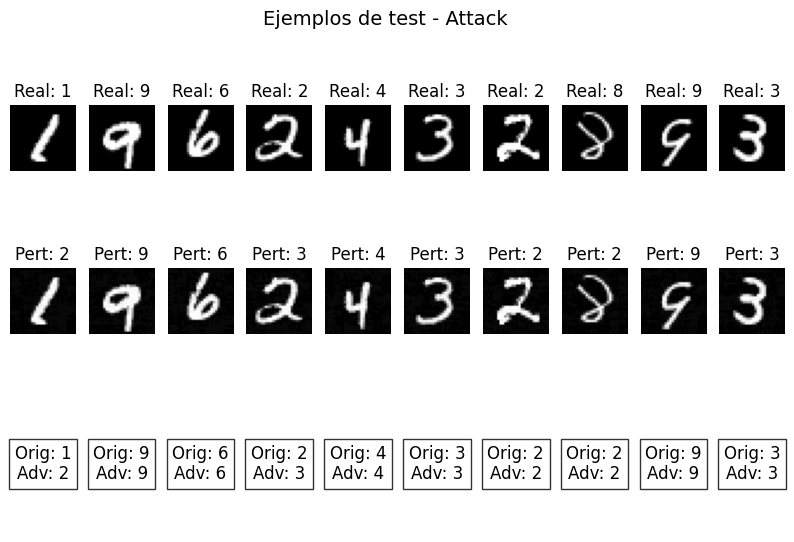

In [41]:
from torchattacks import FGSM  # Asegúrate de tener instalada la librería torchattacks

# Definir el ataque FGSM con el modelo y el valor de epsilon
attack = FGSM(model, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack)


In [42]:
probabilities_attack2(adv_images, batch_x,batch_y)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.49,0.04,0.00,0.00,0.00,0.00,0.47,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
9,0.00,0.00,0.00,0.99,0.00,0.01,0.00,0.00,0.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.26,0.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.99
2,0.00,0.00,0.00,0.00,0.00,0.00,0.98,0.00,0.02,0.00
3,0.00,0.00,0.12,0.87,0.00,0.00,0.00,0.01,0.00,0.00
4,0.00,0.01,0.00,0.00,0.64,0.03,0.00,0.16,0.00,0.17
5,0.00,0.00,0.00,0.99,0.00,0.01,0.00,0.00,0.00,0.00
6,0.00,0.02,0.94,0.01,0.00,0.00,0.00,0.03,0.00,0.00
7,0.00,0.00,0.91,0.07,0.00,0.00,0.00,0.00,0.02,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
9,0.00,0.01,0.07,0.63,0.00,0.29,0.00,0.00,0.00,0.00



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 247/250 (98.80%)
Aciertos después del ataque: 195/250 (78.00%)
Cambio de predicción en 52/250 imágenes (20.80%)


(np.float64(0.988), np.float64(0.78), np.float64(0.208))

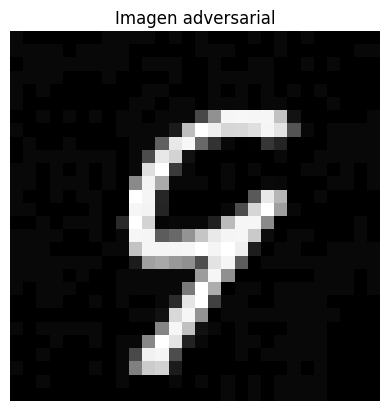

In [43]:
import matplotlib.pyplot as plt

# Convertir a CPU y numpy si es un tensor de PyTorch
img = adv_images[8].cpu().detach().numpy()

# Si la imagen tiene una dimensión de canal (1, 28, 28), la eliminamos con squeeze()
img = img.squeeze()

# Mostrar la imagen
plt.imshow(img, cmap="gray")
plt.axis("off")  # Ocultar ejes
plt.title("Imagen adversarial")
plt.show()


## FGSM Attack adaptaciones

FGSM (Fast Gradient Sign Method) se centra en maximizar la pérdida del modelo respecto a la entrada con una pequeña perturbación adversaria. Sin embargo, puede ser adaptado para atacar diferentes aspectos del modelo dependiendo de cómo se formulen la función de pérdida y las restricciones del ataque.

### 1. Change class untargeted (CU)

Objetivo: Cambiar la clase de la predicción del modelo sin importar a cuál.

- Usamos la pérdida original del modelo (CrossEntropy) con la etiqueta verdadera.
- Calculamos el gradiente respecto a la imagen y perturbamos en la dirección que aumente la pérdida.
- No importa la clase resultante, solo que cambie.



In [44]:
import torch
import torch.nn as nn

class FGSM_ChangeClassUntargeted(Attack):
    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM_CU", model)
        self.eps = eps

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Maximizar la pérdida para hacer que el modelo se equivoque
        loss = nn.CrossEntropyLoss()
        cost = loss(outputs, labels)  # Calculamos la pérdida normal
        cost = -cost  # Negamos la pérdida para maximizar el error

        # Calculamos gradientes y aplicamos perturbación
        grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images


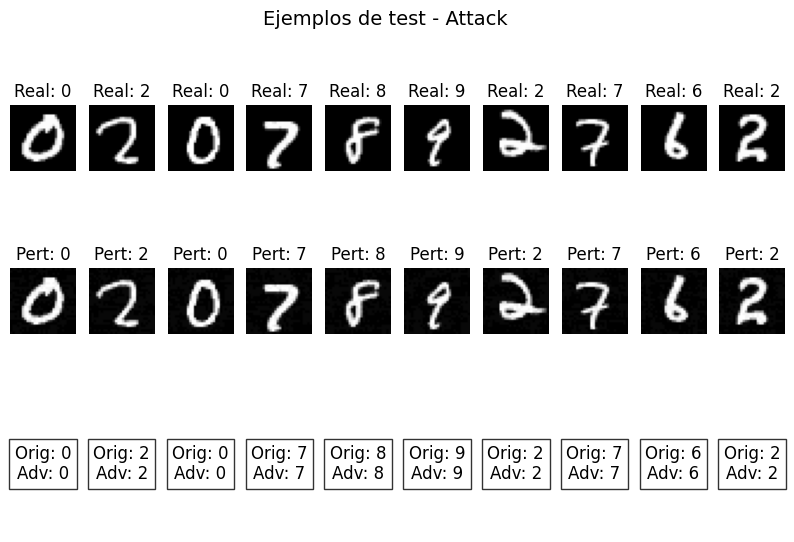

ValueError: too many values to unpack (expected 2)

In [45]:
attack = FGSM_ChangeClassUntargeted(model, eps=8/255)
adv_images, batch_x = Imagenes_attack(attack)



In [ ]:
probabilities_attack(adv_images, batch_x)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


### 2. Change class targeted (CT)

In [ ]:
import torch
import torch.nn as nn

class FGSM_ChangeClassTargeted(Attack):
    def __init__(self, model, eps=8 / 255, target_class=None):
        super().__init__("FGSM_CT", model)
        self.eps = eps
        self.target_class = target_class  # Clase objetivo deseada

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Definir la clase objetivo si no se ha pasado como argumento
        if self.target_class is None:
            target_labels = self.get_target_label(images, labels)  # Algoritmo para seleccionar target
        else:
            target_labels = torch.full_like(labels, self.target_class)  # Fijar clase objetivo

        # Minimizar la pérdida hacia la clase objetivo
        loss = nn.CrossEntropyLoss()
        cost = -loss(outputs, target_labels)  # Minimizar la pérdida para la clase objetivo

        # Calcular gradientes y actualizar la imagen adversarial
        grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images


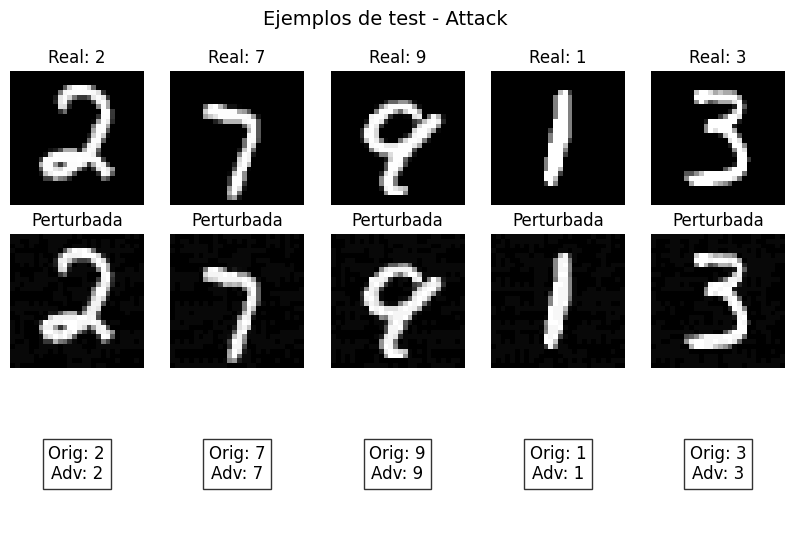

In [ ]:
attack = FGSM_ChangeClassTargeted(model, eps=8/255, target_class=3)  # Clase 3 como objetivo
adv_images, batch_x = Imagenes_attack(attack)


In [ ]:
probabilities_attack(adv_images, batch_x)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.94,0.06,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.01,0.36,0.00,0.00,0.00,0.63,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.80
3,0.00,0.98,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
4,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


### 3. Change explanation untargeted (EU)

In [ ]:
import torch
import torch.nn as nn

class FGSM_Explainability(Attack):
    """
    FGSM adaptado para cambiar la explicación sin cambiar la clase,
    manipulando la asignación a los prototipos.
    """

    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM_Explainability", model)
        self.eps = eps

    def forward(self, images, labels):
        """
        Genera imágenes adversarias que cambian la explicación sin cambiar la clase.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        images.requires_grad = True
        outputs = self.get_logits(images)  # (batch_size, num_classes)

        # Prototipo original (el más cercano)
        original_proto_idx = prototype_distances.argmin(dim=1)  # Índices más cercanos por batch
        original_prototype = prototype_imgs[original_proto_idx]  # (batch_size, 1, 28, 28)

        # Seleccionar otro prototipo dentro de la misma clase (segundo más cercano)
        sorted_indices = torch.argsort(prototype_distances, dim=1)  # Ordena por distancia
        alternative_proto_idx = sorted_indices[:, 1]  # Segundo más cercano
        alternative_prototype = prototype_imgs[alternative_proto_idx]  # (batch_size, 1, 28, 28)

        # Obtener representaciones latentes de los prototipos
        original_proto_repr = self.get_logits(original_prototype.squeeze(1))  # (batch_size, num_classes)
        alternative_proto_repr = self.get_logits(alternative_prototype.squeeze(1))  # (batch_size, num_classes)

        # Definir la función de costo para modificar la asignación de prototipos
        similarity_loss = nn.MSELoss()
        cost = similarity_loss(outputs, alternative_proto_repr) - similarity_loss(outputs, original_proto_repr)

        # Calcular gradiente y generar imagen adversarial
        grad = torch.autograd.grad(cost, images, retain_graph=False, create_graph=False)[0]
        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images


In [ ]:
attack = FGSM_Explainability(model, eps=8/255)
adv_images, batch_x = Imagenes_attack(attack)

IndexError: index 25 is out of bounds for dimension 0 with size 15

In [ ]:
import torch

# Simulación de las distancias (15 prototipos, 40 imágenes)
prototype_distances = torch.rand(15, 40)  # Distancias aleatorias para el ejemplo

# Obtener el índice del prototipo más cercano para cada imagen
closest_prototypes = prototype_distances.argmin(dim=0)

print(closest_prototypes)  # Tensor con 40 valores (uno por imagen)


tensor([ 5, 10,  8,  5,  0, 12,  7, 11, 11,  3, 14,  1, 13,  7,  9,  5, 12,  6,
         6,  2,  3,  1, 10, 12,  3,  0,  7,  9, 12,  5,  9,  4,  8, 11,  8,  6,
        14,  6,  3,  8])


### 4. Change explanation targeted (ET)

In [ ]:
target_explanation = grad_cam(model, target_images)  # Explicación de la clase objetivo
loss = nn.MSELoss()(grad_cam(model, adv_images), target_explanation)  # Minimiza la diferencia con la explicación objetivo
grad = torch.autograd.grad(loss, images)[0]
adv_images = images + epsilon * grad.sign()


### 5. Change explanation and class both untargeted (ECU)

In [ ]:
loss_class = nn.CrossEntropyLoss()(outputs, labels)  # Cambia la clase
loss_explanation = torch.norm(grad_cam(model, adv_images) - grad_cam(model, images), p=2)  # Cambia la explicación
loss = loss_class + loss_explanation  # Combinamos ambas pérdidas
grad = torch.autograd.grad(loss, images)[0]
adv_images = images + epsilon * grad.sign()


### 6. Change explanation and class same target (ECST)

In [ ]:
target_labels = torch.full_like(labels, target_class)
target_explanation = grad_cam(model, target_images)

loss_class = -nn.CrossEntropyLoss()(outputs, target_labels)  # Minimiza la pérdida de la clase objetivo
loss_explanation = nn.MSELoss()(grad_cam(model, adv_images), target_explanation)  # Explicación similar a la de la clase objetivo
loss = loss_class + loss_explanation
grad = torch.autograd.grad(loss, images)[0]
adv_images = images + epsilon * grad.sign()


### 7. Change explanation and class different target (ECDT)

In [ ]:
target_labels = torch.full_like(labels, target_class)  # Clase objetivo
distractor_explanation = grad_cam(model, distractor_images)  # Explicación de otra clase distinta

loss_class = -nn.CrossEntropyLoss()(outputs, target_labels)  # Minimiza la pérdida de la clase objetivo
loss_explanation = nn.MSELoss()(grad_cam(model, adv_images), distractor_explanation)  # Explicación similar a otra clase
loss = loss_class + loss_explanation
grad = torch.autograd.grad(loss, images)[0]
adv_images = images + epsilon * grad.sign()


## PGD Attack

https://arxiv.org/abs/1706.06083

Tipo de ataque: Iterativo y más potente que FGSM.

- Se realiza FGSM en múltiples iteraciones, en pequeños pasos α.
- Se proyecta la imagen en el espacio permitido (manteniendo la perturbación dentro de ϵ).
- Es uno de los ataques más robustos y rompe muchas defensas de redes neuronales.



In [ ]:
import torch
import torch.nn as nn


class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

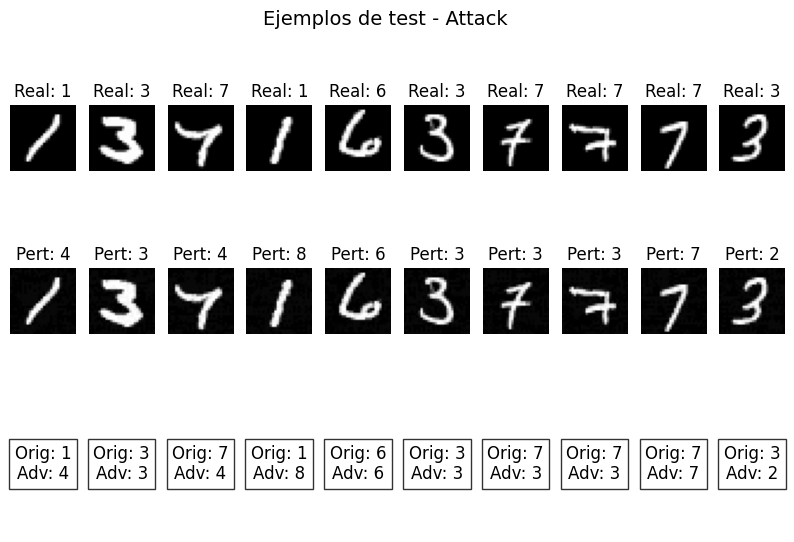

In [ ]:
from torchattacks import PGD 

attack = PGD(model, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack)


In [ ]:
probabilities_attack2(adv_images, batch_x,batch_y)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
5,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
7,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.97,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
9,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.85,0.00,0.00,0.15,0.00,0.00
3,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.98,0.00
4,0.07,0.00,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.00
5,0.00,0.00,0.00,0.99,0.00,0.01,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.71,0.00,0.00,0.00,0.29,0.00,0.00
7,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.04,0.00,0.00,0.01,0.00,0.00,0.88,0.00,0.06
9,0.00,0.00,0.57,0.42,0.00,0.00,0.00,0.01,0.00,0.00



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 250/250 (100.00%)
Aciertos después del ataque: 126/250 (50.40%)
Cambio de predicción en 124/250 imágenes (49.60%)


(np.float64(1.0), np.float64(0.504), np.float64(0.496))

## PGDL2 Attack

https://arxiv.org/abs/1706.06083

PGD-L2 (Projected Gradient Descent en​ L2 )

- En vez de usar el signo del gradiente (como FGSM y PGD), lo normaliza en L2
- El ataque se mueve en la dirección óptima dentro del radio ϵ, pero en una norma L2.
- Menos perceptible visualmente que PGD en L∞​ , pero igual de efectivo.

In [ ]:
import torch
import torch.nn as nn


class PGDL2(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 1.0)
        alpha (float): step size. (Default: 0.2)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGDL2(model, eps=1.0, alpha=0.2, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=1.0,
        alpha=0.2,
        steps=10,
        random_start=True,
        eps_for_division=1e-10,
    ):
        super().__init__("PGDL2", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.eps_for_division = eps_for_division
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()
        batch_size = len(images)

        if self.random_start:
            # Starting at a uniformly random point
            delta = torch.empty_like(adv_images).normal_()
            d_flat = delta.view(adv_images.size(0), -1)
            n = d_flat.norm(p=2, dim=1).view(adv_images.size(0), 1, 1, 1)
            r = torch.zeros_like(n).uniform_(0, 1)
            delta *= r / n * self.eps
            adv_images = torch.clamp(adv_images + delta, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            grad_norms = (
                torch.norm(grad.view(batch_size, -1), p=2, dim=1)
                + self.eps_for_division
            )  # nopep8
            grad = grad / grad_norms.view(batch_size, 1, 1, 1)
            adv_images = adv_images.detach() + self.alpha * grad

            delta = adv_images - images
            delta_norms = torch.norm(delta.view(batch_size, -1), p=2, dim=1)
            factor = self.eps / delta_norms
            factor = torch.min(factor, torch.ones_like(delta_norms))
            delta = delta * factor.view(-1, 1, 1, 1)

            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

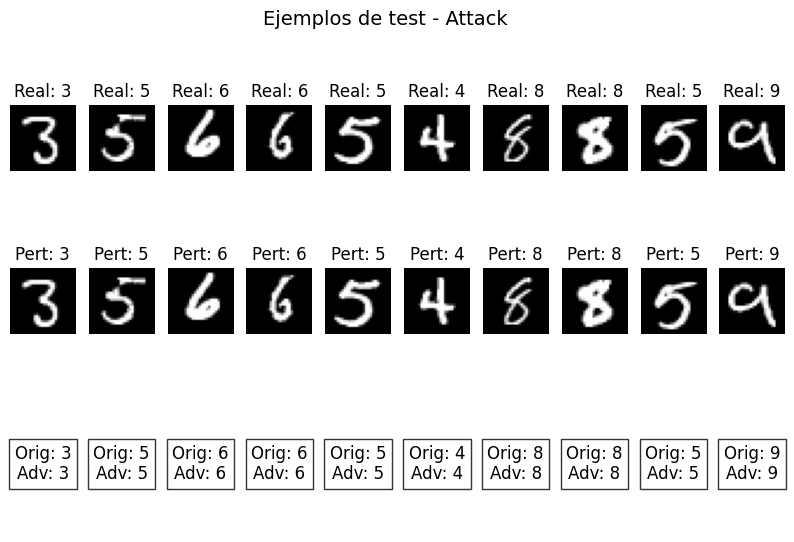

In [ ]:
from torchattacks import PGDL2 

attack = PGDL2(model, eps=8/255)
adv_images, batch_x, batch_y = Imagenes_attack(attack)

In [ ]:
probabilities_attack2(adv_images, batch_x,batch_y)

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
8,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


Probabilidades con ataque:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.01,0.00,0.99,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
8,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00



 Estadísticas del ataque adversarial:
Aciertos antes del ataque: 248/250 (99.20%)
Aciertos después del ataque: 246/250 (98.40%)
Cambio de predicción en 2/250 imágenes (0.80%)


(np.float64(0.992), np.float64(0.984), np.float64(0.008))

## Autoattack

In [ ]:
import time



class AutoAttack(Attack):
    r"""
    AutoAttack in the paper 'Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks'
    [https://arxiv.org/abs/2003.01690]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str) : Lp-norm to minimize. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 0.3)
        version (bool): version. ['standard', 'plus', 'rand'] (Default: 'standard')
        n_classes (int): number of classes. (Default: 10)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10, seed=None, verbose=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        version="standard",
        n_classes=10,
        seed=None,
        verbose=False,
    ):
        super().__init__("AutoAttack", model)
        self.norm = norm
        self.eps = eps
        self.version = version
        self.n_classes = n_classes
        self.seed = seed
        self.verbose = verbose
        self.supported_mode = ["default"]

        if version == "standard":  # ['apgd-ce', 'apgd-t', 'fab-t', 'square']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                ]
            )

        # ['apgd-ce', 'apgd-dlr', 'fab', 'square', 'apgd-t', 'fab-t']
        elif version == "plus":
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=5,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        n_restarts=5,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=5,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                ]
            )

        elif version == "rand":  # ['apgd-ce', 'apgd-dlr']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                ]
            )

        else:
            raise ValueError("Not valid version. ['standard', 'plus', 'rand']")

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self._autoattack(images, labels)

        return adv_images

    def get_seed(self):
        return time.time() if self.seed is None else self.seed

In [ ]:
from torchattacks import PGDL2 

attack = AutoAttack(model, eps=8/255)

NameError: name 'MultiAttack' is not defined

In [ ]:
# Obtener un lote de imágenes y etiquetas del conjunto de test
for batch in test_loader:
    batch_x = batch[0].to(device)  # Imágenes originales
    batch_y = batch[1].to(device)  # Etiquetas verdaderas
    break  # Solo usamos el primer batch para visualizar

# Generar imágenes adversarias
adv_images = attack(batch_x, batch_y)

# Obtener las predicciones antes y después del ataque
pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque

In [ ]:
import matplotlib.pyplot as plt

examples_to_show = 5  # Número de imágenes a visualizar

fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
for i in range(examples_to_show):
    # Imagen original
    axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[0, i].set_title(f"Real: {batch_y[i].item()}")
    axes[0, i].axis("off")

    # Imagen perturbada
    axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[1, i].set_title(f"Perturbada")
    axes[1, i].axis("off")

    # Predicción antes y después del ataque
    axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                    ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    axes[2, i].axis("off")

fig.suptitle("Ejemplos de test - PGDL2 Attack", fontsize=14)
plt.show()


In [ ]:
import torch.nn.functional as F
import pandas as pd

probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()

df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])

print("Probabilidades originales:")
display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

print("Probabilidades con ataque FGSM:")
display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

## PGDLInf_attack

In [ ]:
# Adapted version of https://github.com/Harry24k/adversarial-attacks-pytorch/blob/master/torchattacks/attacks/pgd.py 
def PGDLInf_attack(batch_x, loss_f, iters, eps, alpha, random_start):
    """
    Performs the Projected Gradient Descent (PGD) attack with L-infinity norm on a batch of input images.

    Args:
        batch_x (torch.Tensor): The batch of input images.
        loss_f (callable): The loss function to maximize.
        iters (int): The number of iterations for the attack.
        eps (float): The maximum perturbation allowed for each pixel.
        alpha (float): The step size for each iteration of the attack.
        random_start (bool): Whether to start the attack from a random point.

    Returns:
        torch.Tensor: The perturbed batch of input images.

    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define the device
    
    ori_images = batch_x.clone().detach().to(device).to(device)
    perturbed_batch_x = batch_x.clone().detach().to(device)
    
    if random_start:
        # Starting at a uniformly random point
        perturbed_batch_x = perturbed_batch_x + torch.empty_like(perturbed_batch_x).uniform_(
            -eps, eps
        )
        perturbed_batch_x = torch.clamp(perturbed_batch_x, min=0, max=1).detach()
    
    
    for _ in range(iters):
        perturbed_batch_x.requires_grad = True
        
        loss = loss_f(batch_x = perturbed_batch_x)
        
        input_gradients = torch.autograd.grad(loss, perturbed_batch_x)[0]
        input_gradient_sign = torch.sign(input_gradients)

        perturbed_batch_x = perturbed_batch_x.detach() + alpha * input_gradient_sign
        delta = torch.clamp(perturbed_batch_x - ori_images, min=-eps, max=eps)
        perturbed_batch_x = torch.clamp(ori_images + delta, min=0, max=1).detach()
        
    return perturbed_batch_x

## DeepFool attack 

In [ ]:
import torch
import torch.nn as nn

from ..attack import Attack


class DeepFool(Attack):
    r"""
    'DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks'
    [https://arxiv.org/abs/1511.04599]
    Distance Measure : L2
    Arguments:
        model (nn.Module): model to attack.
        steps (int): number of steps. (Default: 50)
        overshoot (float): parameter for enhancing the noise. (Default: 0.02)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.DeepFool(model, steps=50, overshoot=0.02)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, steps=50, overshoot=0.02):
        super().__init__("DeepFool", model)
        self.steps = steps
        self.overshoot = overshoot
        self.supported_mode = ["default"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        adv_images, target_labels = self.forward_return_target_labels(images, labels)
        return adv_images

    def forward_return_target_labels(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        batch_size = len(images)
        correct = torch.tensor([True] * batch_size)
        target_labels = labels.clone().detach().to(self.device)
        curr_steps = 0

        adv_images = []
        for idx in range(batch_size):
            image = images[idx : idx + 1].clone().detach()
            adv_images.append(image)

        while (True in correct) and (curr_steps < self.steps):
            for idx in range(batch_size):
                if not correct[idx]:
                    continue
                early_stop, pre, adv_image = self._forward_indiv(
                    adv_images[idx], labels[idx]
                )
                adv_images[idx] = adv_image
                target_labels[idx] = pre
                if early_stop:
                    correct[idx] = False
            curr_steps += 1

        adv_images = torch.cat(adv_images).detach()
        return adv_images, target_labels

    def _forward_indiv(self, image, label):
        image.requires_grad = True
        fs = self.get_logits(image)[0]
        _, pre = torch.max(fs, dim=0)
        if pre != label:
            return (True, pre, image)

        ws = self._construct_jacobian(fs, image)
        image = image.detach()

        f_0 = fs[label]
        w_0 = ws[label]

        wrong_classes = [i for i in range(len(fs)) if i != label]
        f_k = fs[wrong_classes]
        w_k = ws[wrong_classes]

        f_prime = f_k - f_0
        w_prime = w_k - w_0
        value = torch.abs(f_prime) / torch.norm(nn.Flatten()(w_prime), p=2, dim=1)
        _, hat_L = torch.min(value, 0)

        delta = (
            torch.abs(f_prime[hat_L])
            * w_prime[hat_L]
            / (torch.norm(w_prime[hat_L], p=2) ** 2)
        )

        target_label = hat_L if hat_L < label else hat_L + 1

        adv_image = image + (1 + self.overshoot) * delta
        adv_image = torch.clamp(adv_image, min=0, max=1).detach()
        return (False, target_label, adv_image)

    # https://stackoverflow.com/questions/63096122/pytorch-is-it-possible-to-differentiate-a-matrix
    # torch.autograd.functional.jacobian is only for torch >= 1.5.1
    def _construct_jacobian(self, y, x):
        x_grads = []
        for idx, y_element in enumerate(y):
            if x.grad is not None:
                x.grad.zero_()
            y_element.backward(retain_graph=(False or idx + 1 < len(y)))
            x_grads.append(x.grad.clone().detach())
        return torch.stack(x_grads).reshape(*y.shape, *x.shape)